# Exercises

In [67]:
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator

### Data preparation

To better organize the workflow and manage the numerous datasets in this notebook, we have created a loop that iterates through the datasets stored in the folder assigned to our group. It loads each dataset into a DataFrame object and stores them in a list of DataFrames. This allows us to iterate over the list if we want to perform operations on all 10 datasets, avoiding the need to read the datasets repeatedly.

In [3]:
# List to hold all DataFrames
dataframes = []

# Iterate over files in the directory
for f in os.listdir('./ProjectDatasets/Team_7'):
    if f.endswith('.csv'):  # Check if it's a CSV file
        df = pd.read_csv(os.path.join('./ProjectDatasets/Team_7', f))
        df['Company'] = os.path.splitext(f)[0]  # Add a Company column using the filename (without extension)
        # Ensure the 'Date' column is parsed as datetime
        df['Date'] = pd.to_datetime(df['Date'])
        dataframes.append(df)

We define the columns that are numerical and relative to the stock price, so we can call this list when we need it to iterate through these columns to make transformations.

In [4]:
num_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

We have also created a single combined DataFrame in case it proves useful for any exercise.

In [5]:
merged_df = pd.concat(dataframes, ignore_index=True)
columns = ['Company'] + [col for col in merged_df.columns if col != 'Company']
dfm = merged_df[columns]

#### Missing data

In [6]:
results = []
company_names = []

for df in dataframes:
    company_name = df["Company"][0]
    company_names.append(company_name)
    total_rows = len(df)
    null_percentages = (df.isnull().sum() / total_rows) * 100
    
    result = {"Company": company_name}
    result.update(null_percentages.to_dict())
    results.append(result)

final_df = pd.DataFrame(results, index=company_names)
final_df = final_df.round(2)
final_df

Company  Date  Open  High   Low  Close  Adj Close  Volume
BRK-A      0.0   0.0  4.89  4.85  4.93   4.87       4.85    5.00
DNUT       0.0   0.0  5.03  4.79  4.91   4.79       4.91    4.91
DPZ        0.0   0.0  4.83  4.87  4.89   4.87       4.91    4.99
LKNCY      0.0   0.0  4.81  4.96  4.89   4.67       4.89    4.96
MCD        0.0   0.0  4.90  4.88  4.89   4.81       4.89    5.00
PZZA       0.0   0.0  4.76  4.83  4.88   4.90       4.86    5.00
QSR        0.0   0.0  0.00  0.00  0.00   0.00       0.00    0.00
SBUX       0.0   0.0  4.85  4.84  4.88   4.95       4.88    5.00
WEN        0.0   0.0  4.89  4.83  4.86   4.91       4.88    4.99
YUM        0.0   0.0  4.90  4.87  4.88   4.94       4.87    5.01

In [7]:
print(company_names)

['BRK-A', 'DNUT', 'DPZ', 'LKNCY', 'MCD', 'PZZA', 'QSR', 'SBUX', 'WEN', 'YUM']


As we can observe, there are around 5% missing observations for each variable in each company, except for the company QSR, which has no missing data.

#### Outliers

First, we need to identify whether there are outliers in the datasets and how they are distributed. To do this, we use boxplots for each variable and each company.

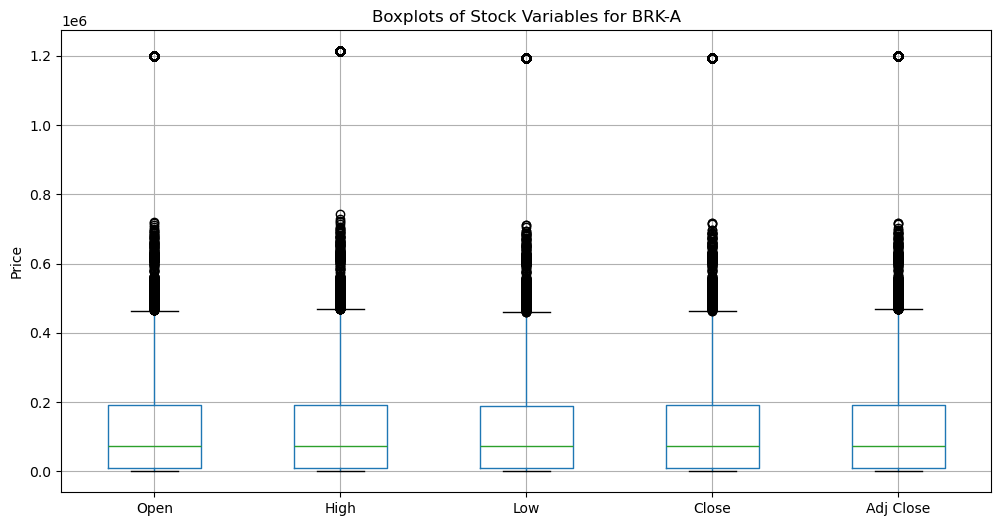

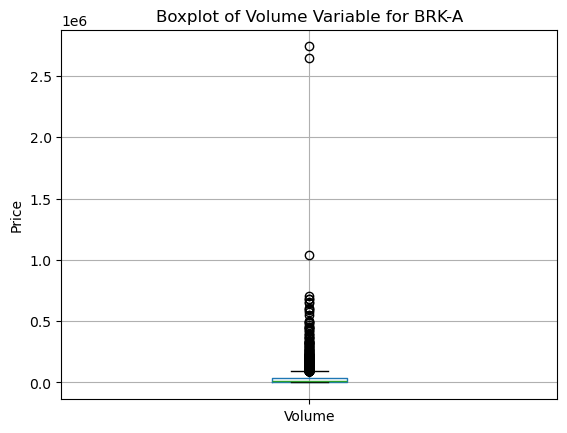

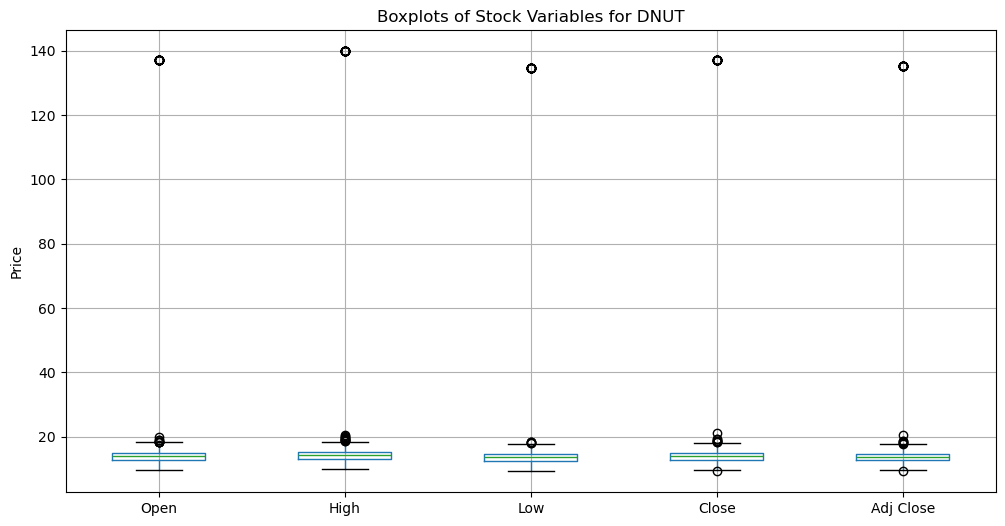

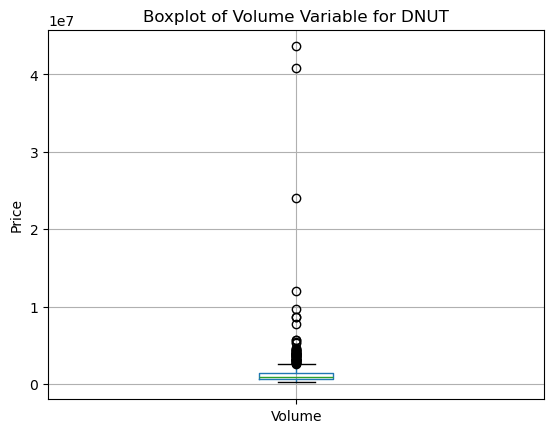

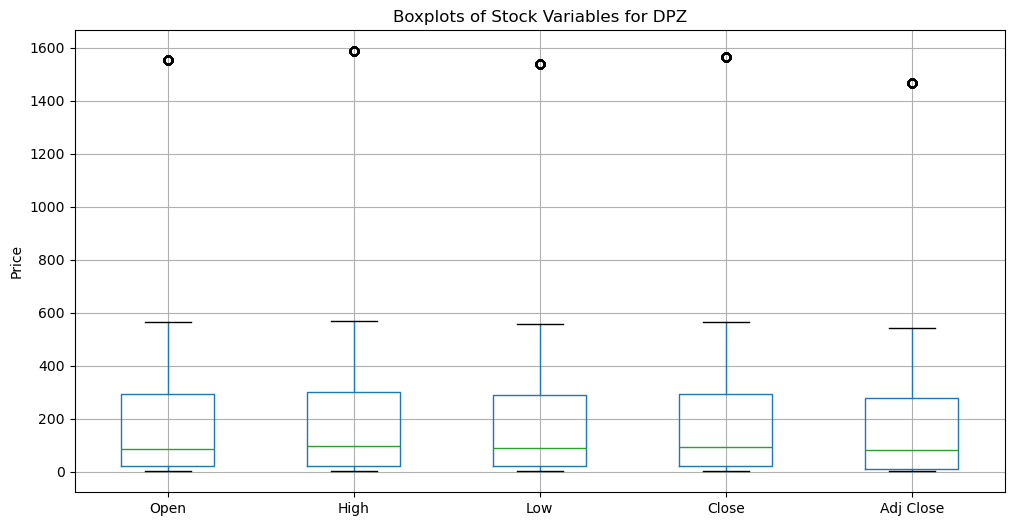

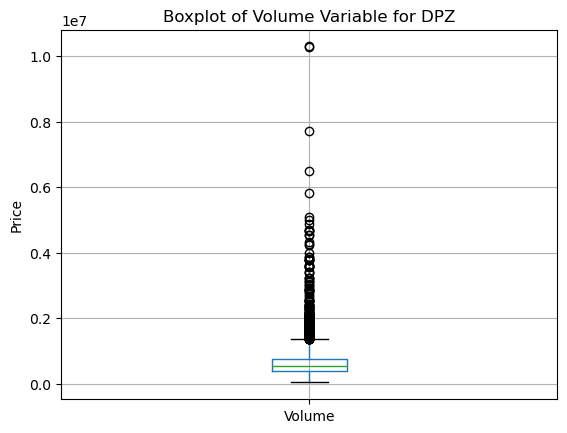

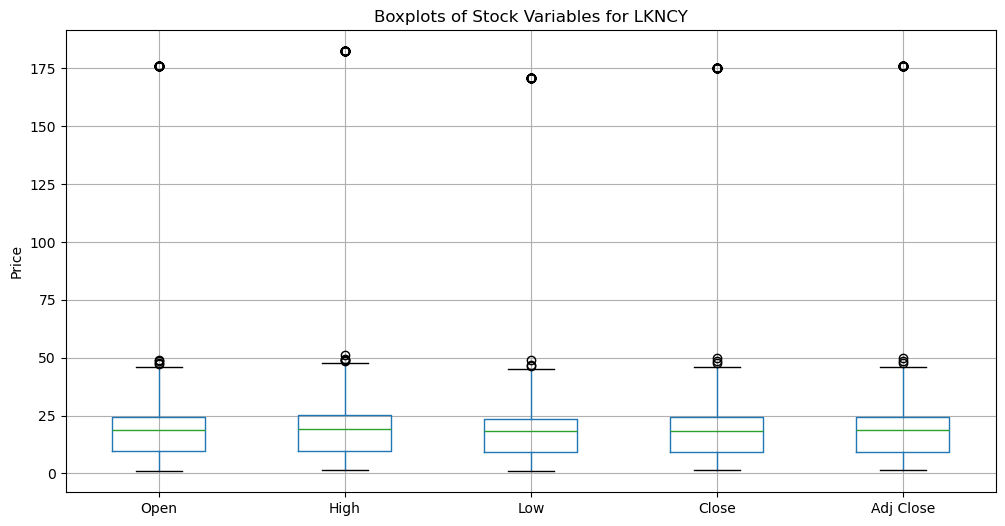

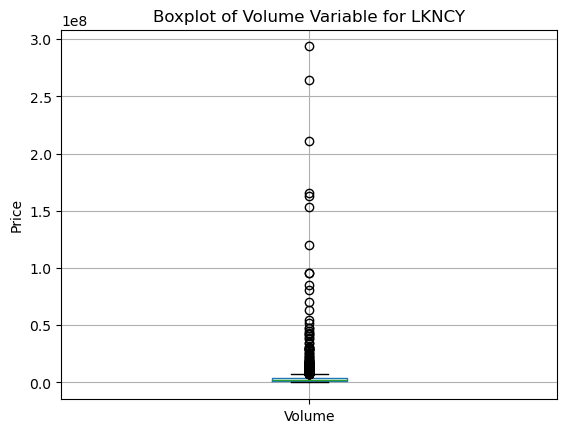

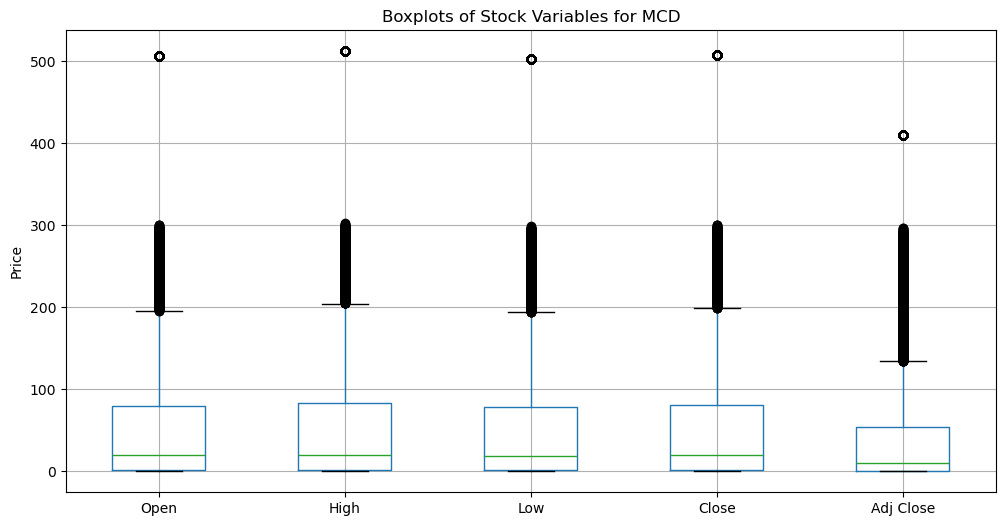

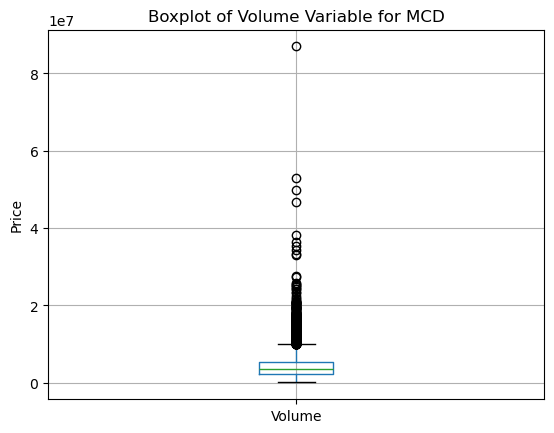

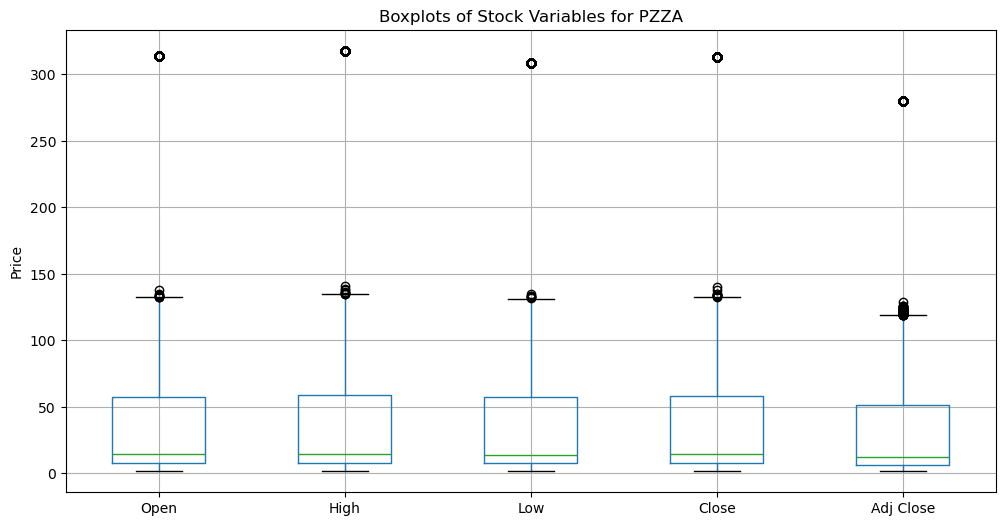

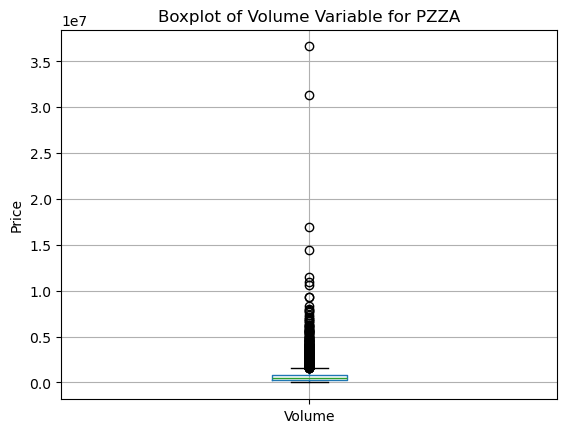

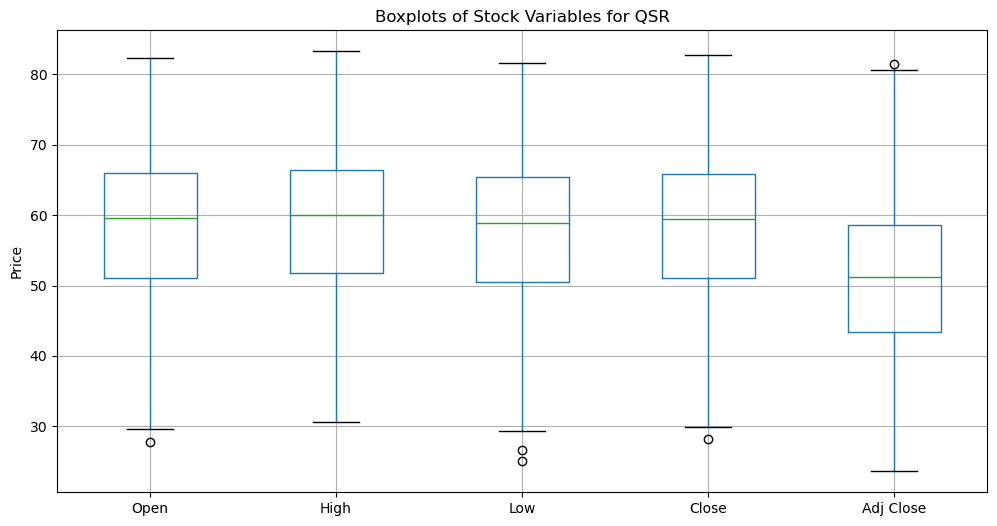

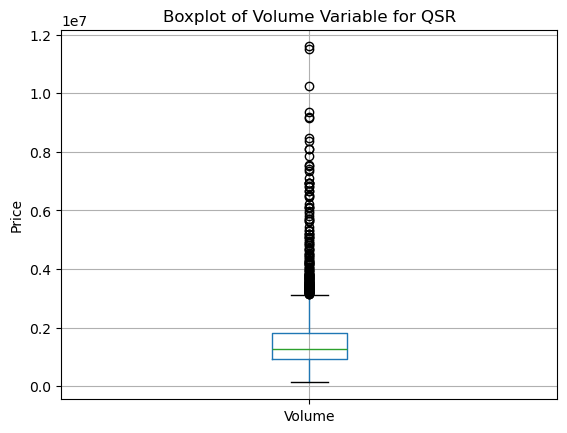

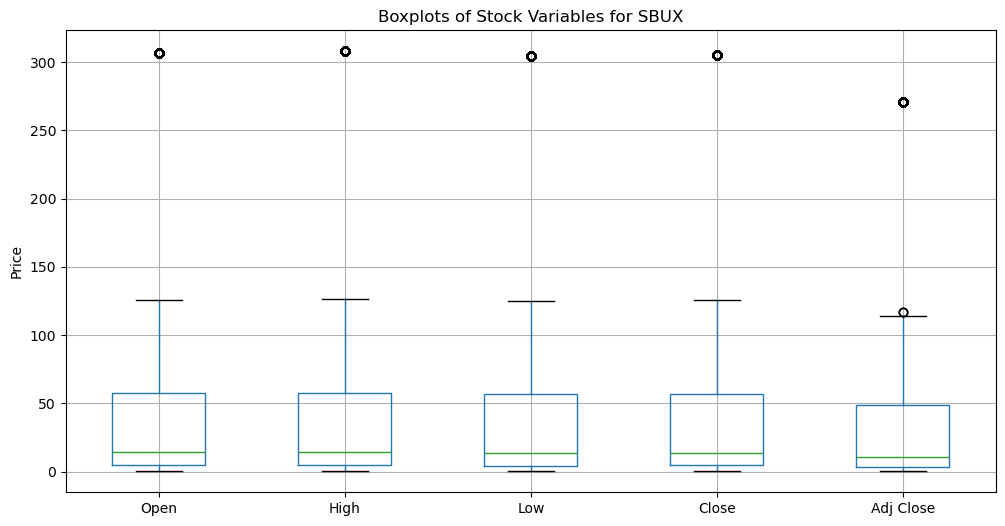

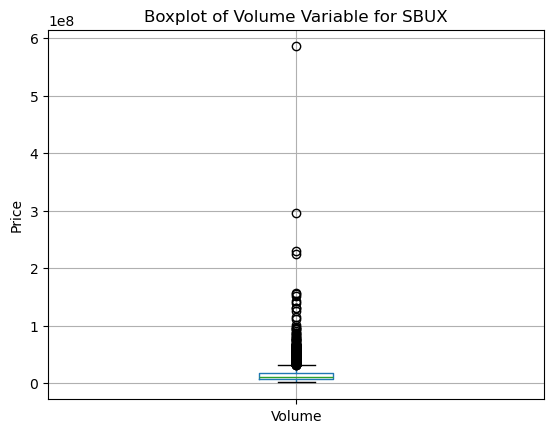

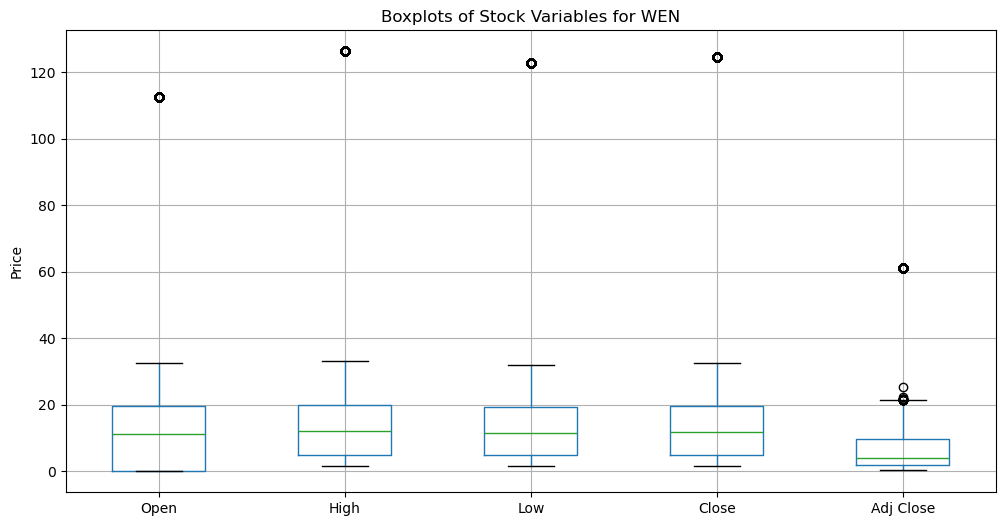

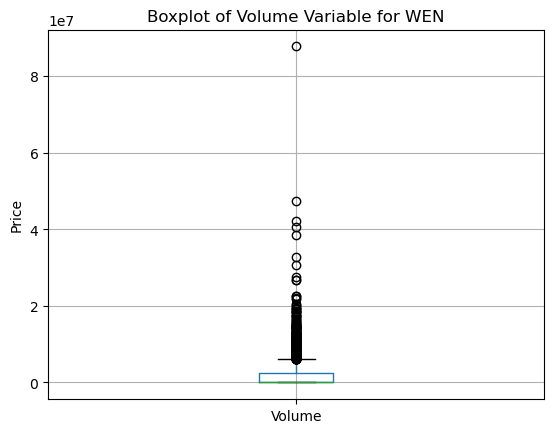

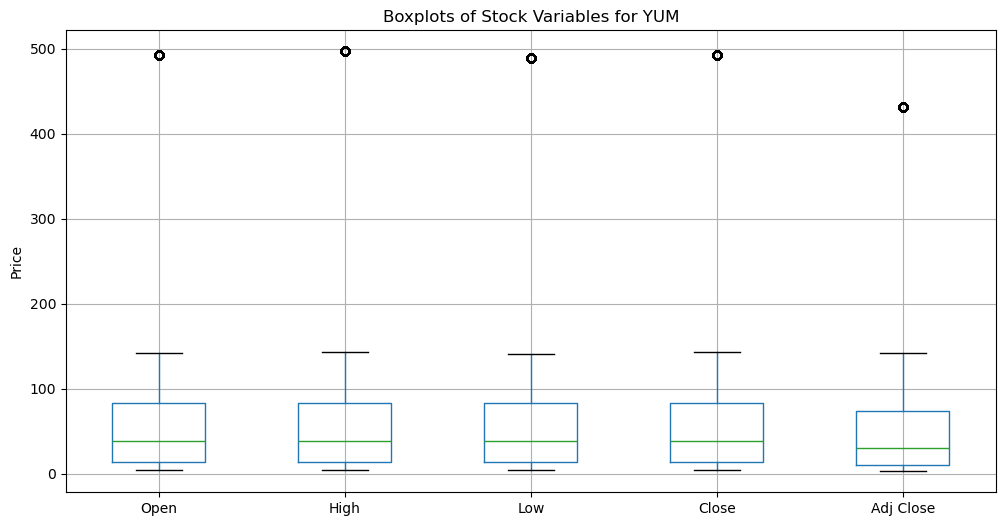

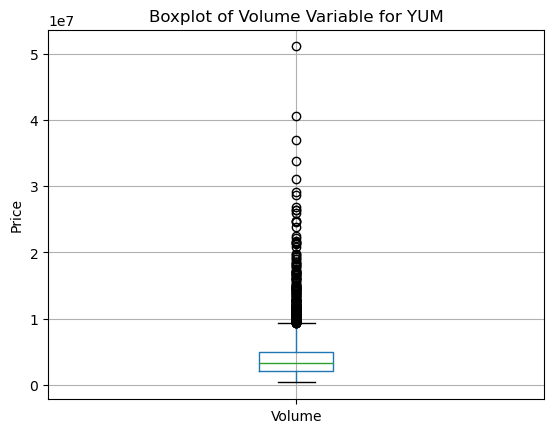

In [8]:
for df in dataframes:
    company_name = df["Company"][0]
    
    # Create a boxplot for each variable
    plt.figure(figsize=(12, 6))
    df[num_columns[:-1]].boxplot()
    plt.title(f"Boxplots of Stock Variables for {company_name}")
    plt.ylabel('Price')
    plt.grid(True, axis='y')
    plt.show()

    plt.figure()
    df[["Volume"]].boxplot()
    plt.title(f"Boxplot of Volume Variable for {company_name}")
    plt.ylabel('Price')
    plt.grid(True, axis='y')
    plt.show()

It can be observed that all datasets, except for the one from the company QSR, exhibit significant outliers. For the other nine companies, these outliers are located above the 75th percentile, falling into specific ranges considerably higher than this threshold.

To detect outliers and replace them with missing values, given the context of financial time series, we have opted for an approach utilizing sliding windows. The use of sliding windows in financial time series allows us to capture local trends and adapt to dynamic changes in the data, such as seasonal variations or periods of high volatility. This is achieved by using a sliding window (`rolling window`) to calculate the **local median** of each numeric column and comparing the current values to this central trend.

The criterion for identifying an outlier is based on the **relative change**, which measures how much a value deviates from the median relative to its magnitude. If the relative change exceeds a predefined threshold, the value is considered an outlier.

Process Steps
1. **Calculate the sliding median (`rolling_median`)**:
   - A sliding window of size `window_size` is used to calculate the median at each point in the time series.
   - The median is chosen instead of the mean because it is more robust to extreme values (outliers), preventing these values from affecting the central reference.

2. **Fill NaN values at the edges**:
   - Sliding windows produce `NaN` values at the edges of the series, so these are filled using forward (`bfill`) and backward (`ffill`) interpolations to maintain continuity.

3. **Calculate the relative change**:
   - The relative change is defined as:
     $$
     \text{Relative Change} = \frac{|x_t - \text{rolling\_median}|}{\text{rolling\_median}}
     $$
   - This value measures how far a point is from the local central trend.

4. **Identify outliers**:
   - A value is considered an outlier if its relative change exceeds a predefined threshold (`threshold`, e.g., 0.25 or 25%, making the detection highly sensitive).

5. **Replace outliers with `NaN`**:
   - Values identified as outliers are replaced with `NaN` in the DataFrame to prevent them from impacting future analyses.

In [9]:
window_size = 10
threshold = 0.25

for df in dataframes:
    print(df["Company"][0])
    print(f"Rows in {df["Company"][0]}: {df.shape[0]}")
    print(df.isnull().sum())

    for column in num_columns:

        rolling_median = df[column].rolling(window=window_size, center=True).median()
        rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')

        relative_change = abs(df[column] - rolling_median) / rolling_median

        outliers = relative_change > threshold
        print(f"Outliers detected in {column}: {outliers.sum()}")

        df.loc[outliers, column] = np.nan

    print(df.isnull().sum())
    print("******************************************************************************")


BRK-A
Rows in BRK-A: 11227
Date           0
Open         549
High         545
Low          553
Close        547
Adj Close    545
Volume       561
Company        0
dtype: int64
Outliers detected in Open: 286
Outliers detected in High: 286
Outliers detected in Low: 290
Outliers detected in Close: 286
Outliers detected in Adj Close: 285
Outliers detected in Volume: 5984
Date            0
Open          835
High          831
Low           843
Close         833
Adj Close     830
Volume       6545
Company         0
dtype: int64
******************************************************************************
DNUT
Rows in DNUT: 815
Date          0
Open         41
High         39
Low          40
Close        39
Adj Close    40
Volume       40
Company       0
dtype: int64
Outliers detected in Open: 22
Outliers detected in High: 30
Outliers detected in Low: 41
Outliers detected in Close: 24
Outliers detected in Adj Close: 22
Outliers detected in Volume: 301
Date           0
Open          63
High    

C:\Users\nelso\AppData\Local\Temp\ipykernel_8776\95997536.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
C:\Users\nelso\AppData\Local\Temp\ipykernel_8776\95997536.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
C:\Users\nelso\AppData\Local\Temp\ipykernel_8776\95997536.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
C:\Users\nelso\AppData\Local\Temp\ipykernel_8776\95997536.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.

Outliers detected in Open: 148
Outliers detected in High: 137
Outliers detected in Low: 143
Outliers detected in Close: 132
Outliers detected in Adj Close: 140
Outliers detected in Volume: 2136
Date            0
Open          394
High          385
Low           392
Close         380
Adj Close     390
Volume       2390
Company         0
dtype: int64
******************************************************************************
LKNCY
Rows in LKNCY: 1350
Date          0
Open         65
High         67
Low          66
Close        63
Adj Close    66
Volume       67
Company       0
dtype: int64
Outliers detected in Open: 73
Outliers detected in High: 82
Outliers detected in Low: 68
Outliers detected in Close: 80
Outliers detected in Adj Close: 77
Outliers detected in Volume: 708
Date           0
Open         138
High         149
Low          134
Close        143
Adj Close    143
Volume       775
Company        0
dtype: int64
******************************************************************

C:\Users\nelso\AppData\Local\Temp\ipykernel_8776\95997536.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
C:\Users\nelso\AppData\Local\Temp\ipykernel_8776\95997536.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
C:\Users\nelso\AppData\Local\Temp\ipykernel_8776\95997536.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
C:\Users\nelso\AppData\Local\Temp\ipykernel_8776\95997536.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.

Outliers detected in Close: 373
Outliers detected in Adj Close: 376
Outliers detected in Volume: 6000
Date            0
Open         1112
High         1088
Low          1090
Close        1078
Adj Close    1093
Volume       6733
Company         0
dtype: int64
******************************************************************************
PZZA
Rows in PZZA: 7883
Date           0
Open         375
High         381
Low          385
Close        386
Adj Close    383
Volume       394
Company        0
dtype: int64
Outliers detected in Open: 210
Outliers detected in High: 217
Outliers detected in Low: 206
Outliers detected in Close: 223
Outliers detected in Adj Close: 212
Outliers detected in Volume: 3863
Date            0
Open          585
High          598
Low           591
Close         609
Adj Close     595
Volume       4257
Company         0
dtype: int64
******************************************************************************
QSR
Rows in QSR: 2459
Date         0
Open         0
High   

C:\Users\nelso\AppData\Local\Temp\ipykernel_8776\95997536.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
C:\Users\nelso\AppData\Local\Temp\ipykernel_8776\95997536.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
C:\Users\nelso\AppData\Local\Temp\ipykernel_8776\95997536.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
C:\Users\nelso\AppData\Local\Temp\ipykernel_8776\95997536.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.

Outliers detected in Low: 0
Outliers detected in Close: 0
Outliers detected in Adj Close: 0
Outliers detected in Volume: 947
Date           0
Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume       947
Company        0
dtype: int64
******************************************************************************
SBUX
Rows in SBUX: 8122
Date           0
Open         394
High         393
Low          396
Close        402
Adj Close    396
Volume       406
Company        0
dtype: int64
Outliers detected in Open: 224
Outliers detected in High: 215
Outliers detected in Low: 251
Outliers detected in Close: 226
Outliers detected in Adj Close: 217
Outliers detected in Volume: 3034
Date            0
Open          618
High          608
Low           647
Close         628
Adj Close     613
Volume       3440
Company         0
dtype: int64
******************************************************************************
WEN
Rows in WEN: 11192
Date           0
Open

C:\Users\nelso\AppData\Local\Temp\ipykernel_8776\95997536.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
C:\Users\nelso\AppData\Local\Temp\ipykernel_8776\95997536.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
C:\Users\nelso\AppData\Local\Temp\ipykernel_8776\95997536.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
C:\Users\nelso\AppData\Local\Temp\ipykernel_8776\95997536.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.

We can now check again the outliers present in the boxplots. We can observe how there considerably less outliers.

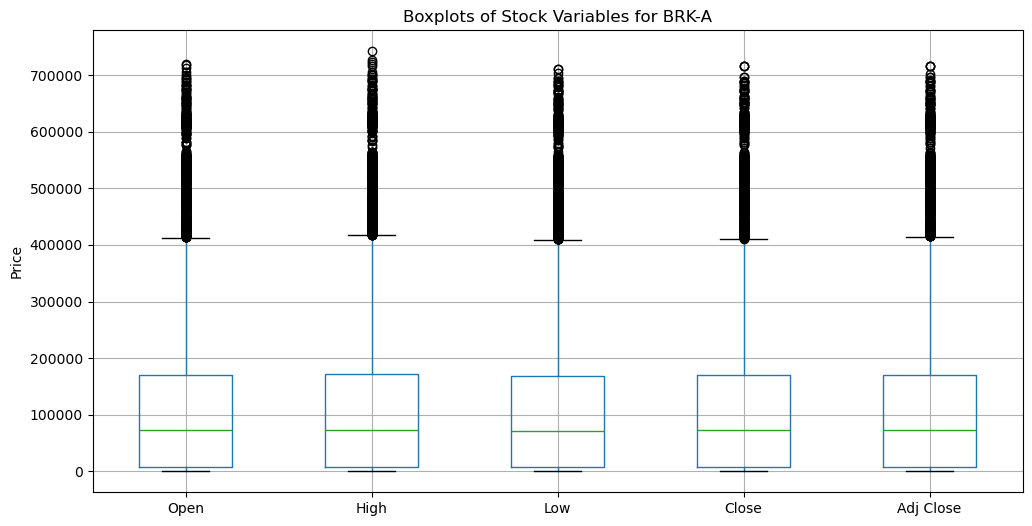

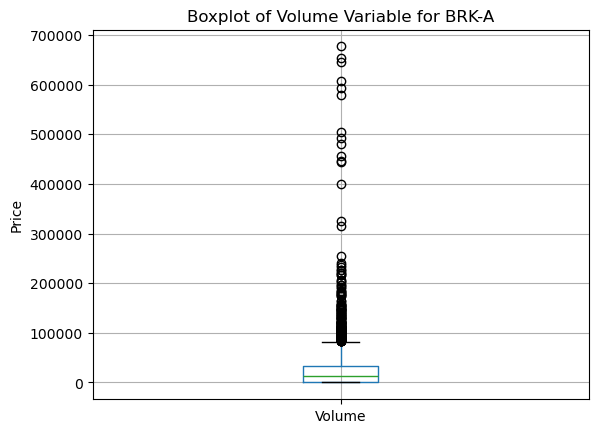

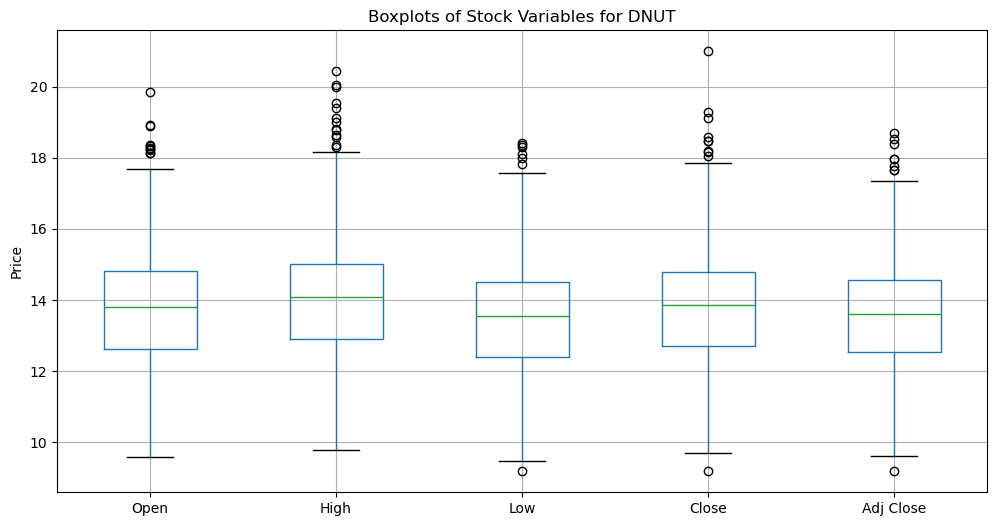

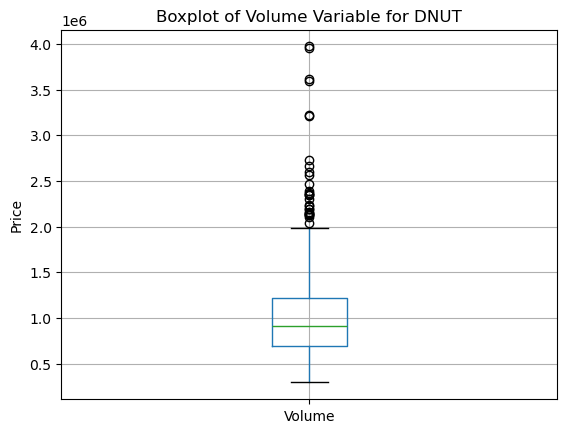

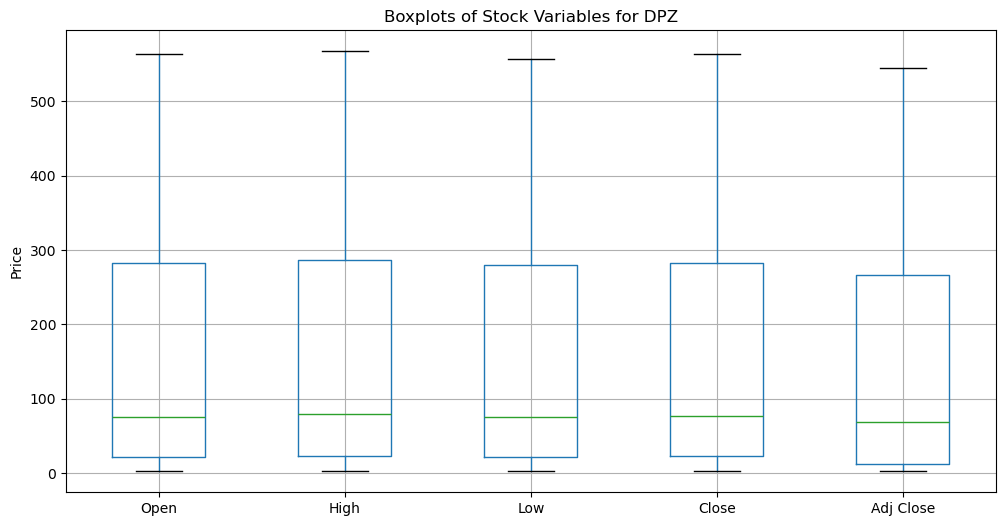

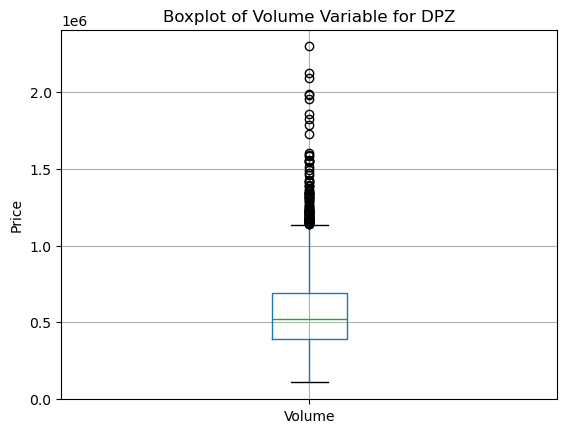

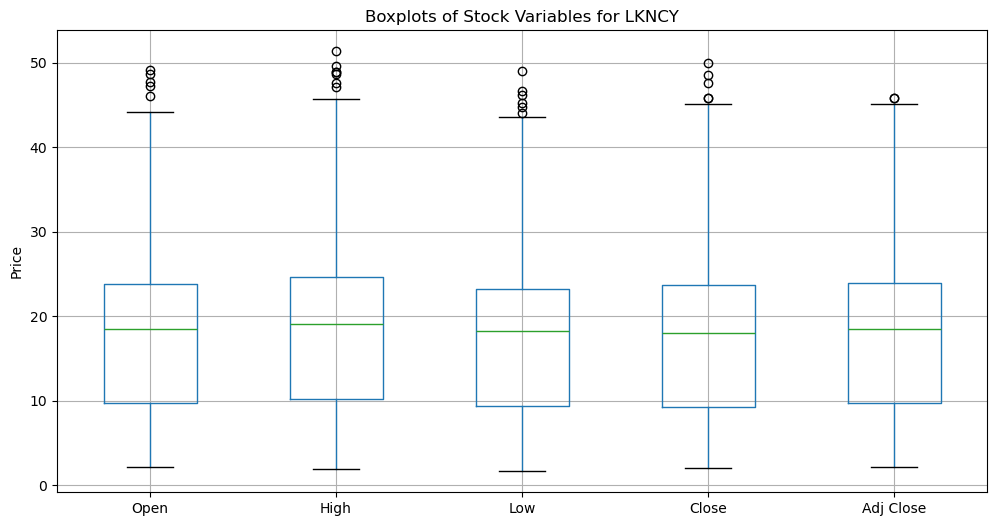

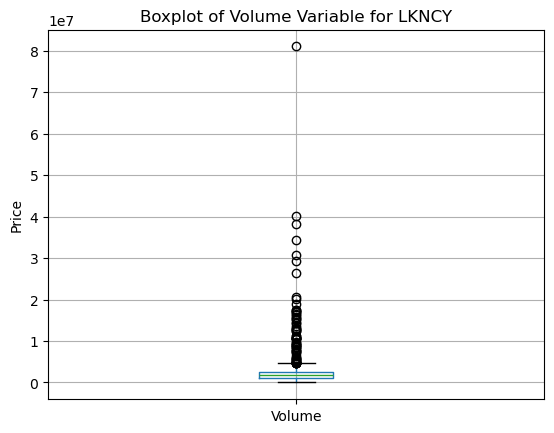

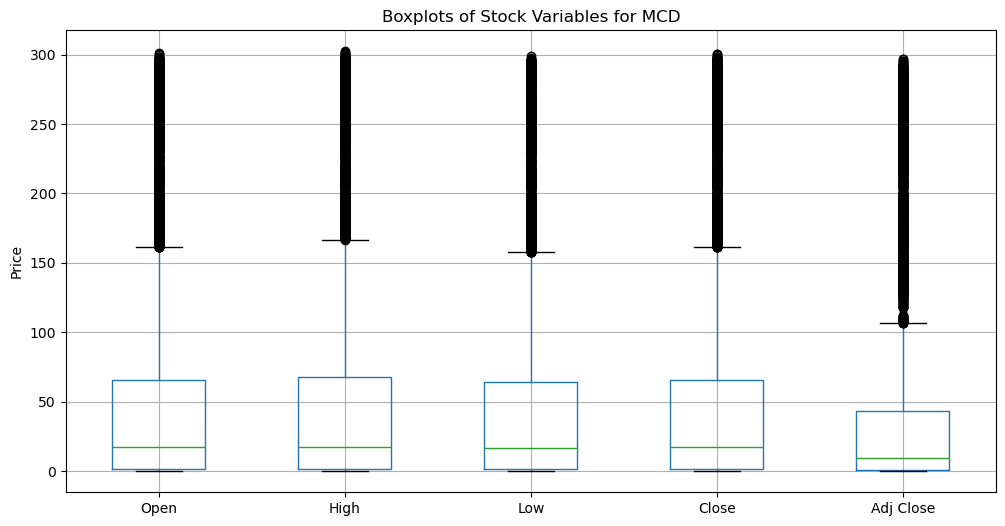

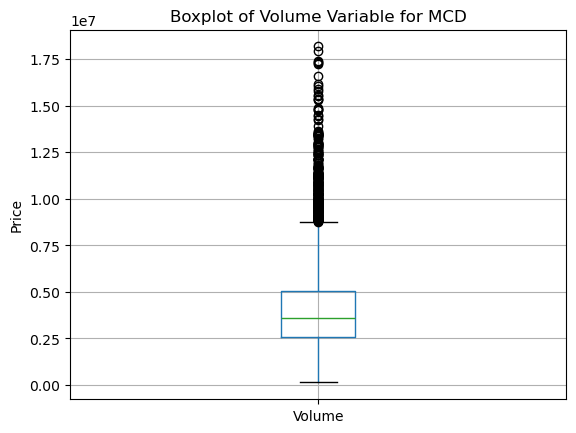

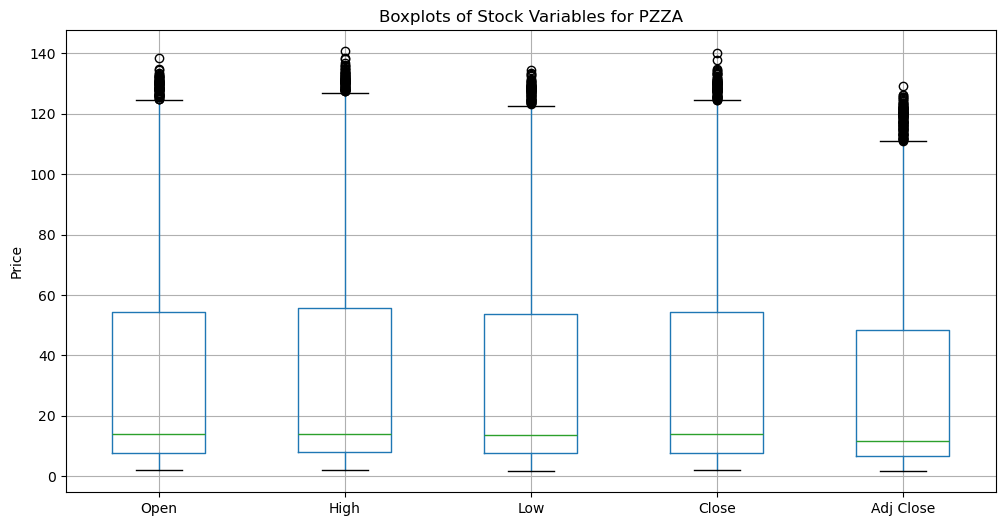

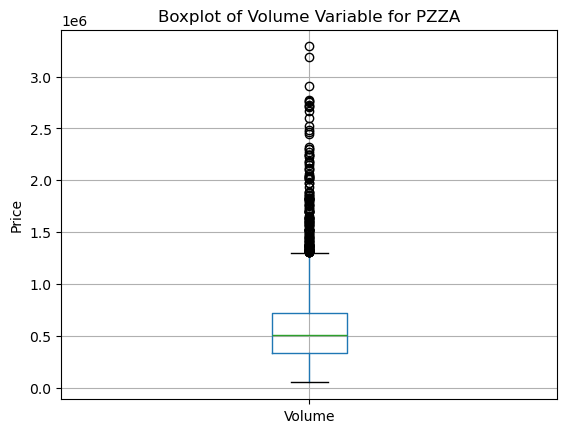

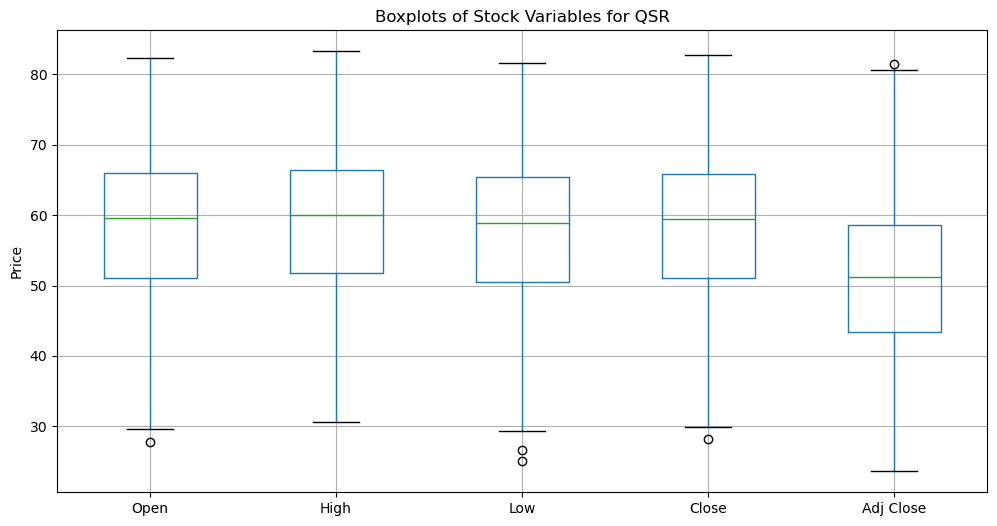

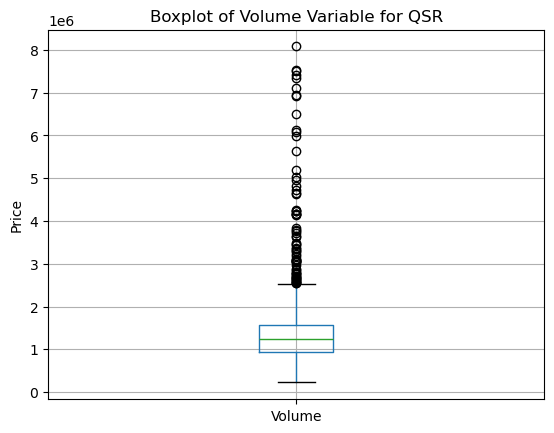

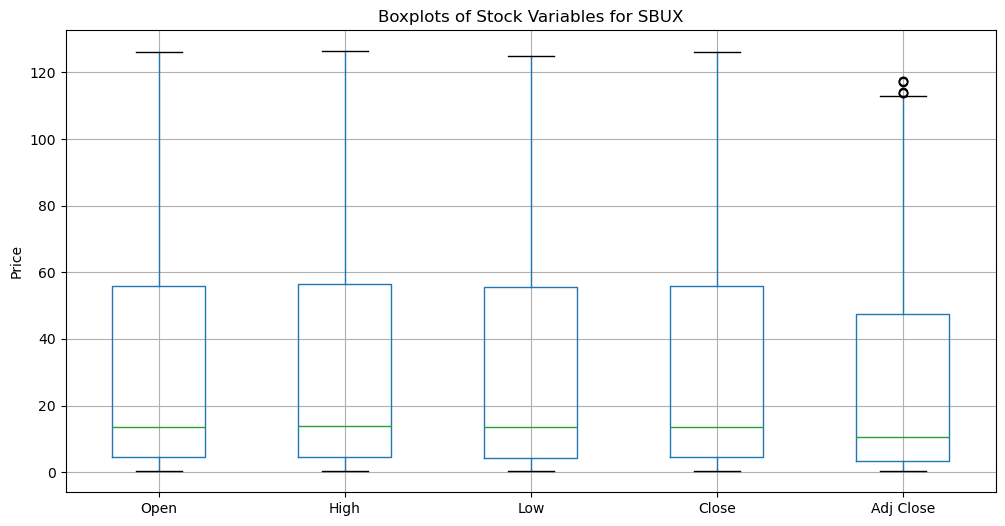

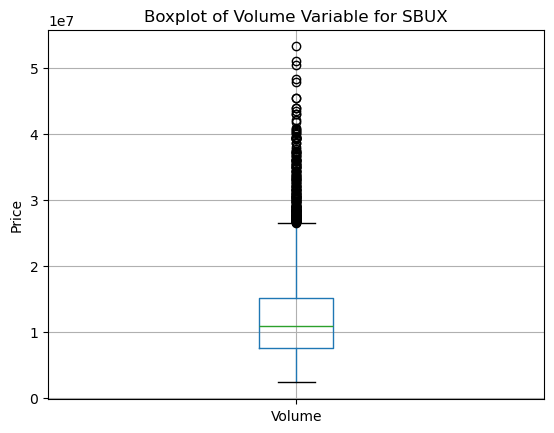

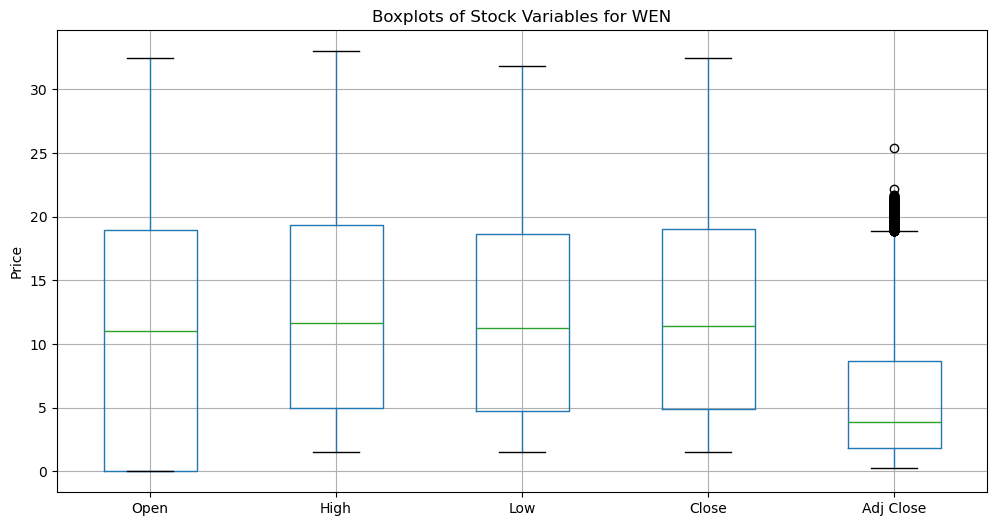

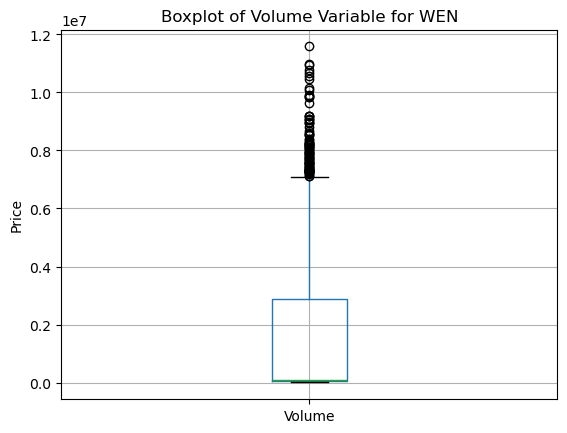

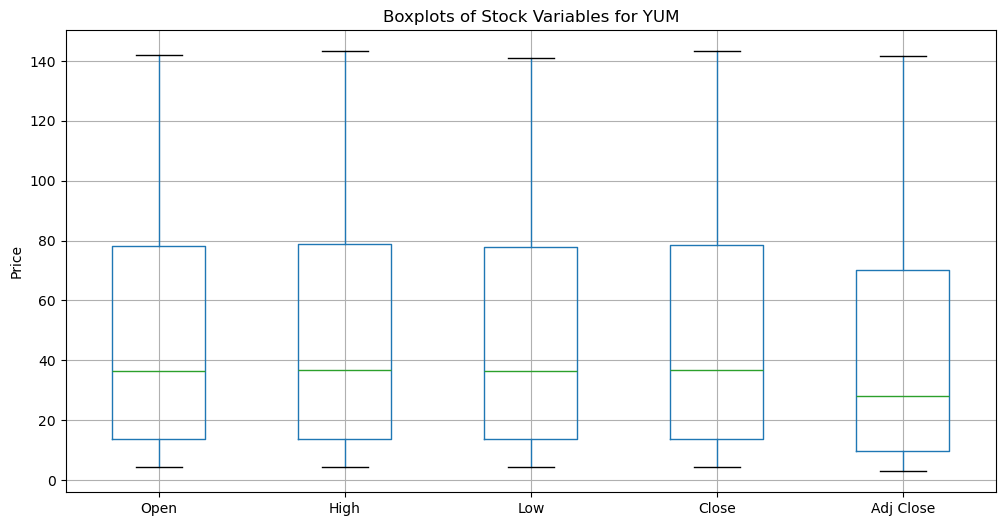

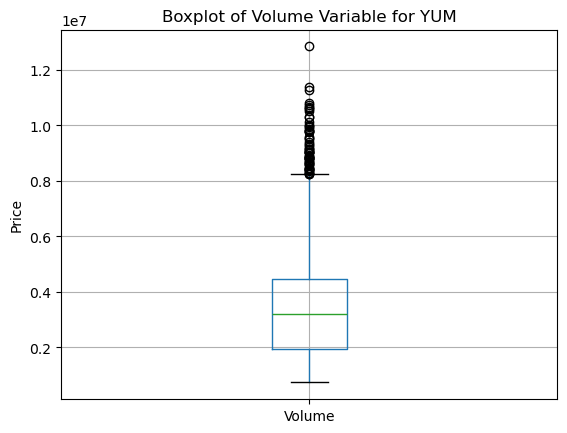

In [10]:
for df in dataframes:
    company_name = df["Company"][0]
    
    # Create a boxplot for each variable
    plt.figure(figsize=(12, 6))
    df[num_columns[:-1]].boxplot()
    plt.title(f"Boxplots of Stock Variables for {company_name}")
    plt.ylabel('Price')
    plt.grid(True, axis='y')
    plt.show()

    plt.figure()
    df[["Volume"]].boxplot()
    plt.title(f"Boxplot of Volume Variable for {company_name}")
    plt.ylabel('Price')
    plt.grid(True, axis='y')
    plt.show()

As we can also observe in the output of the cell where outliers were replaced with NaN values, this transformation has resulted in a large number of missing values for the "Volume" variable in each company. As shown in the following tables, the number of missing values for the "Volume" variable exceeds 50% of the observations in some cases.

In [11]:
results = []
company_names = []

for df in dataframes:
    company_name = df["Company"][0]
    company_names.append(company_name)
    total_rows = len(df)
    null_percentages = (df.isnull().sum() / total_rows) * 100
    
    result = {"Company": company_name}
    result.update(null_percentages.to_dict())
    results.append(result)

final_df = pd.DataFrame(results, index=company_names)
final_df = final_df.round(2)
final_df

Company  Date   Open   High   Low  Close  Adj Close  Volume
BRK-A      0.0   0.0   7.44   7.40  7.51   7.42       7.39   58.30
DNUT       0.0   0.0   7.73   8.47  9.94   7.73       7.61   41.84
DPZ        0.0   0.0   7.74   7.57  7.70   7.47       7.67   46.97
LKNCY      0.0   0.0  10.22  11.04  9.93  10.59      10.59   57.41
MCD        0.0   0.0   7.59   7.42  7.44   7.35       7.46   45.94
PZZA       0.0   0.0   7.42   7.59  7.50   7.73       7.55   54.00
QSR        0.0   0.0   0.00   0.00  0.00   0.00       0.00   38.51
SBUX       0.0   0.0   7.61   7.49  7.97   7.73       7.55   42.35
WEN        0.0   0.0   7.69   7.46  7.78   7.55       7.63   58.66
YUM        0.0   0.0   7.45   7.59  7.72   7.60       7.45   42.61

In [12]:
for df in dataframes:
    print(df["Volume"].describe())

count      4682.000000
mean      24485.604443
std       40390.048950
min           0.000000
25%        1300.000000
50%       13850.000000
75%       34000.000000
max      676900.000000
Name: Volume, dtype: float64
count    4.740000e+02
mean     1.052312e+06
std      5.462934e+05
min      2.934000e+05
25%      6.972000e+05
50%      9.068500e+05
75%      1.221525e+06
max      3.973000e+06
Name: Volume, dtype: float64
count    2.698000e+03
mean     5.707537e+05
std      2.583418e+05
min      1.062000e+05
25%      3.915000e+05
50%      5.180500e+05
75%      6.880000e+05
max      2.299200e+06
Name: Volume, dtype: float64
count    5.750000e+02
mean     3.149202e+06
std      5.555511e+06
min      0.000000e+00
25%      1.169250e+06
50%      1.761800e+06
75%      2.586800e+06
max      8.098610e+07
Name: Volume, dtype: float64
count    7.924000e+03
mean     4.054297e+06
std      2.223119e+06
min      1.336500e+05
25%      2.564775e+06
50%      3.590600e+06
75%      5.040250e+06
max      1.818580e

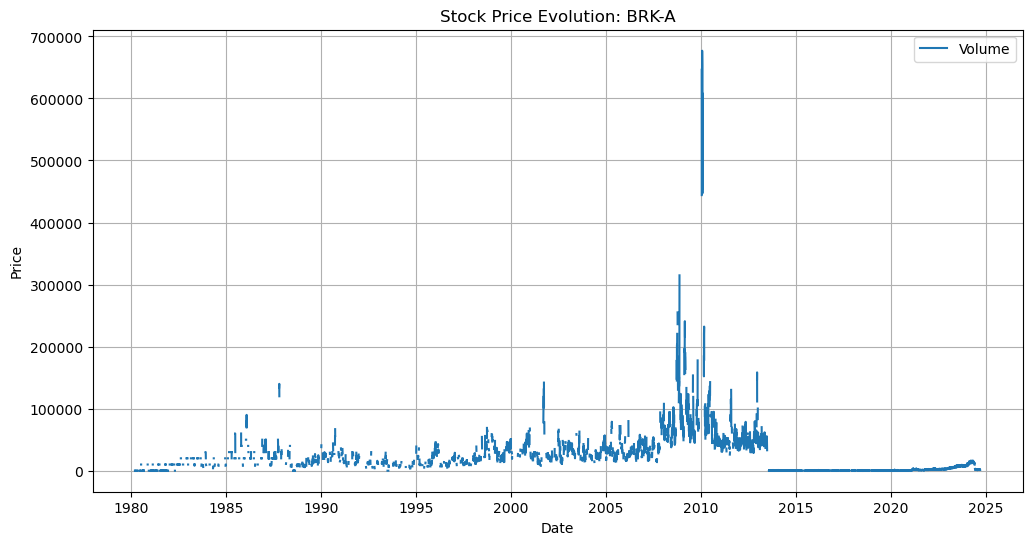

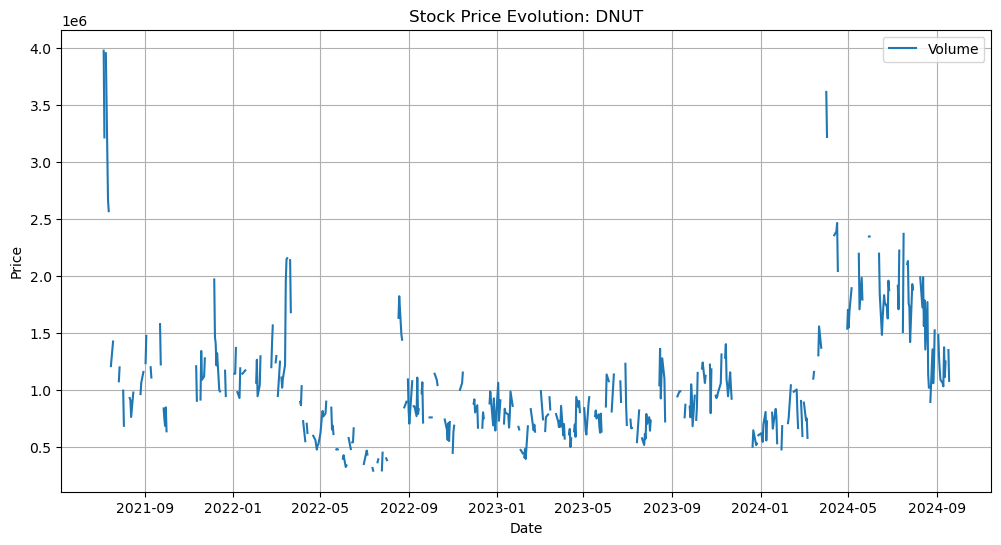

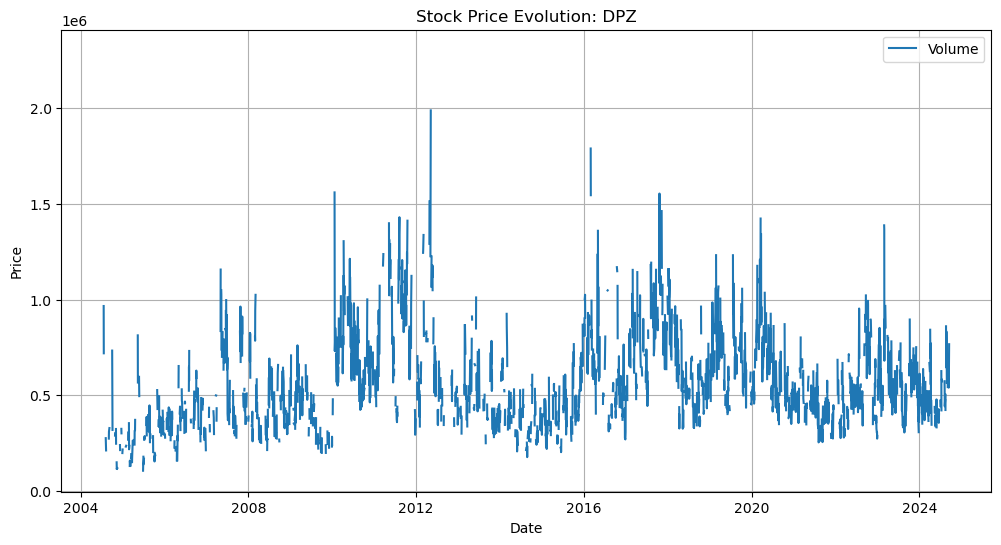

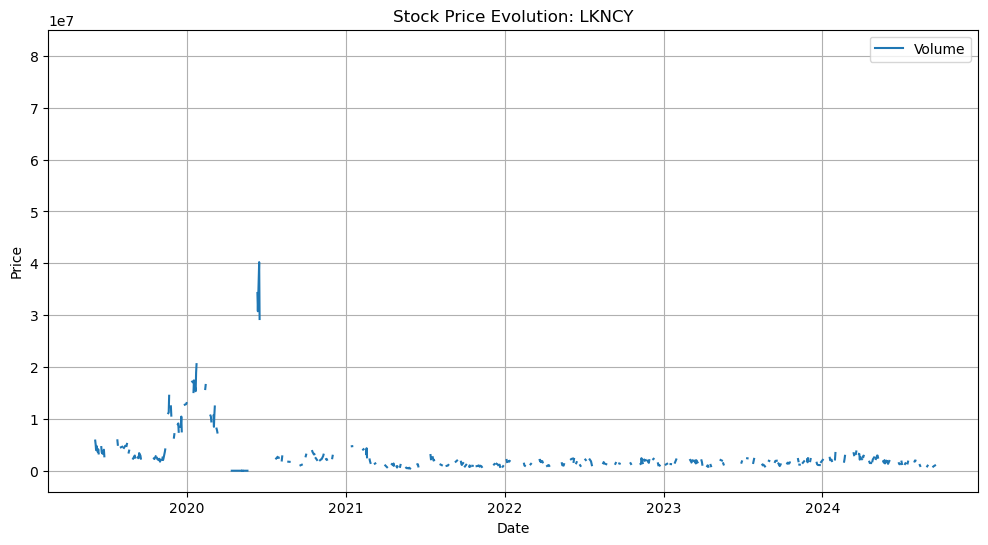

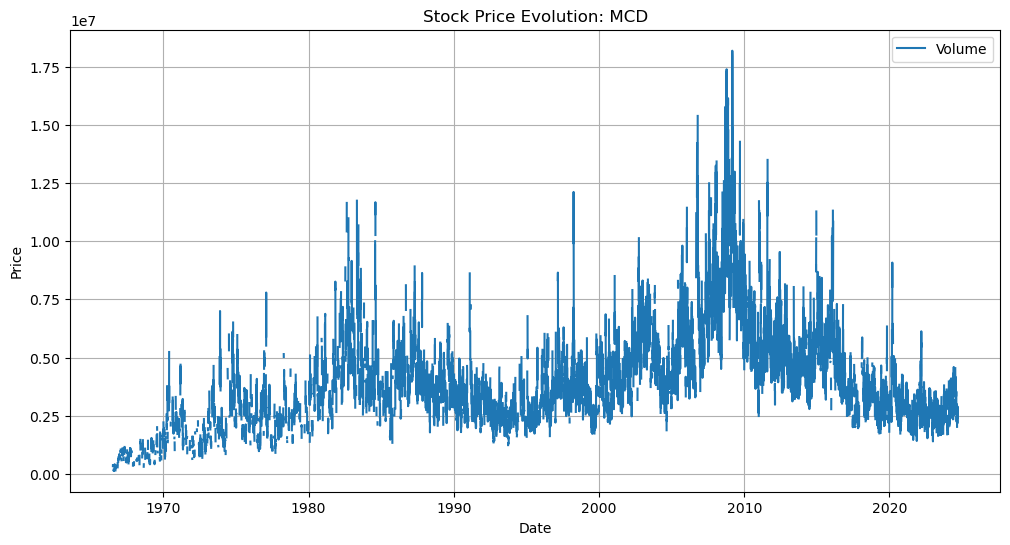

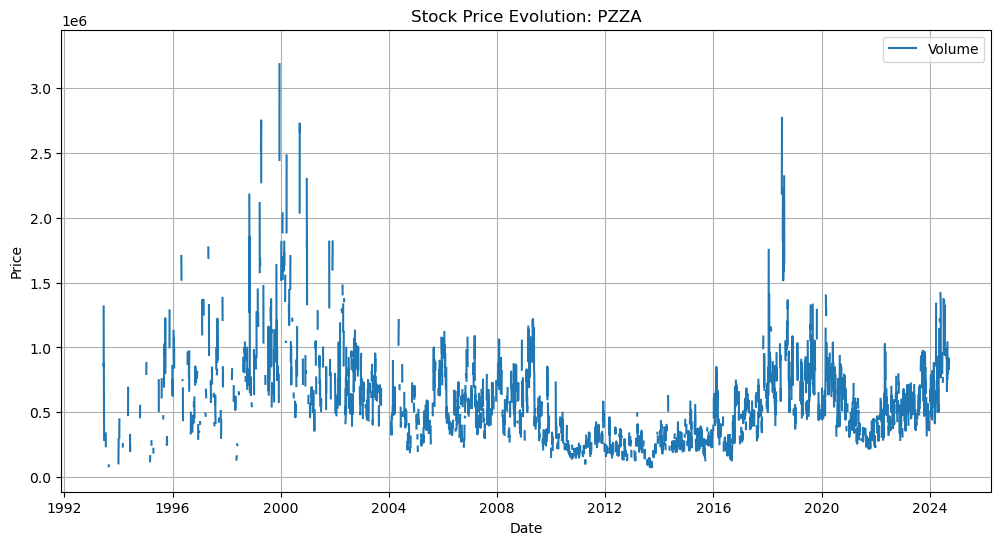

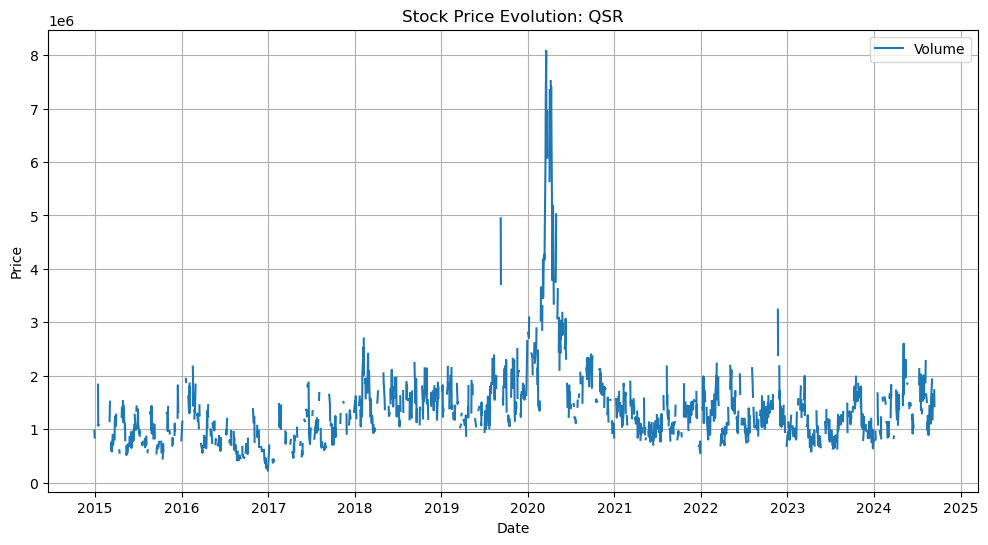

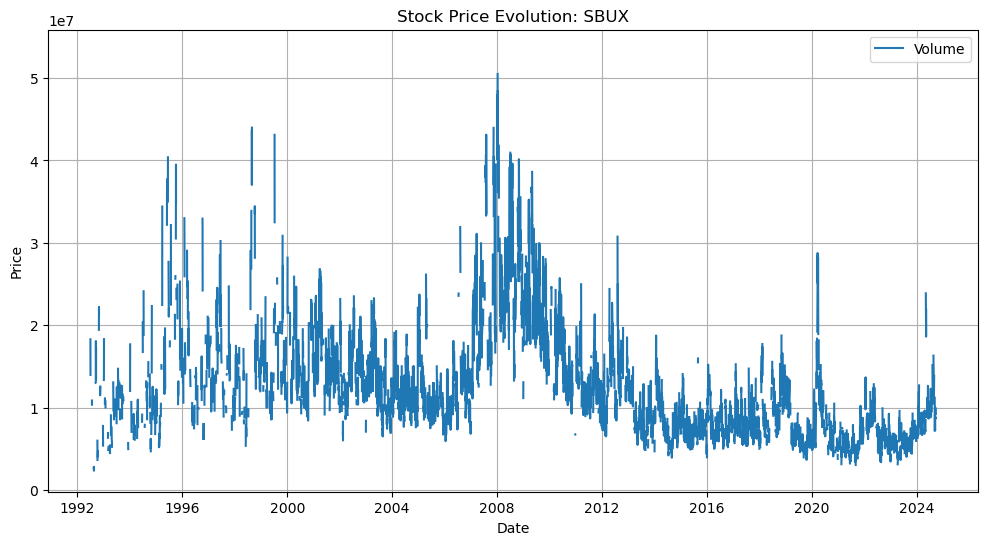

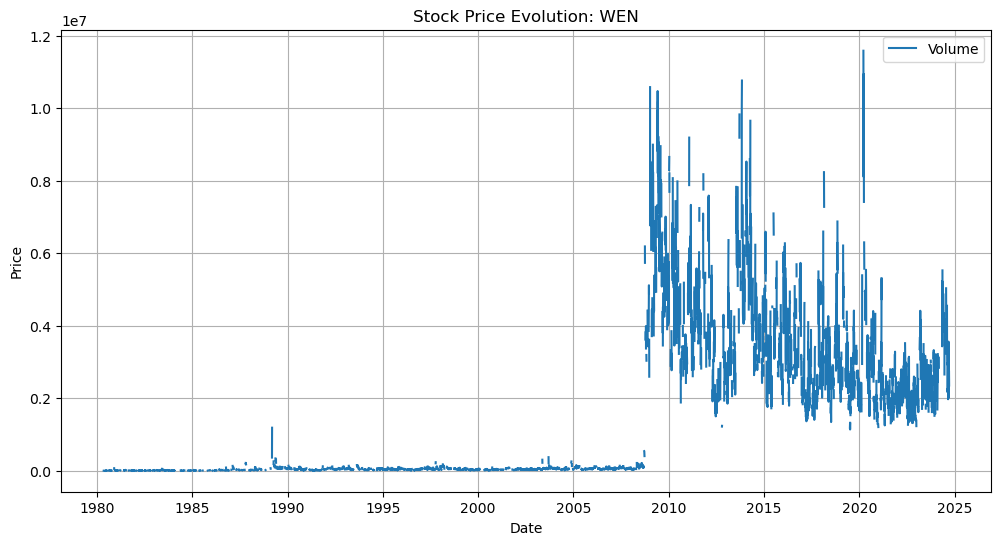

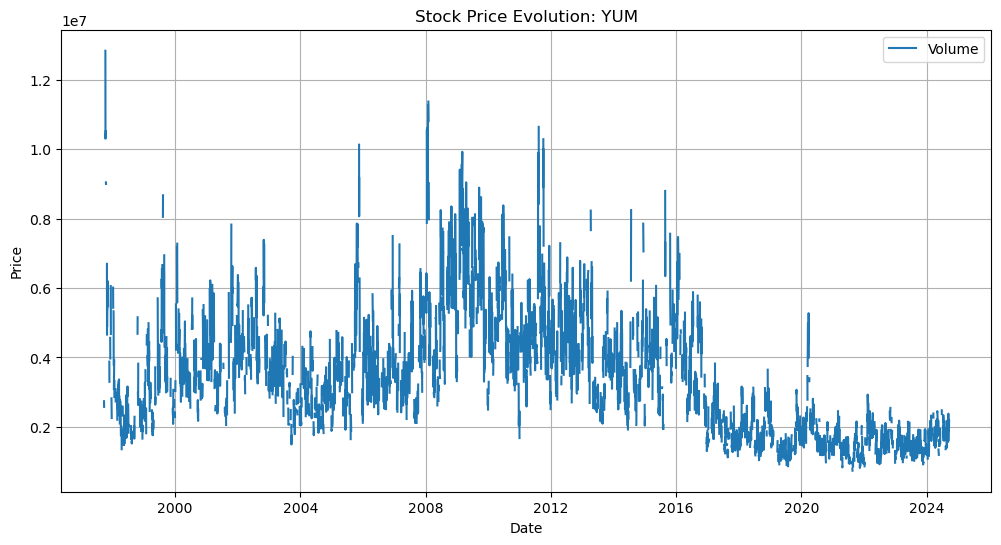

In [13]:
for df in dataframes:
    # Ensure the 'Date' column is parsed as datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort the data by date for proper plotting
    df.sort_values('Date', inplace=True)
    
    # Plot the line chart
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Volume'], label='Volume')
        
    # Chart formatting
    plt.title(f"Stock Price Evolution: {df["Company"][0]}")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Replace Missing Data

We used **interpolation** as the primary technique to replace missing values in the time series. Interpolation involves estimating the missing values based on adjacent known data, leveraging the continuity of the time series.

Interpolation Process
1. **Method Selection**:
   - We opted for **linear interpolation**, which assumes that data changes uniformly between the nearest known points.
   - This method is suitable for time series with smooth transitions and relatively stable patterns.

2. **Filling Missing Values**:
   - Each `NaN` value was estimated by calculating the slope between the nearest known points (previous and next) and assigning a proportional value within the interval.
   - For values at the start or end of the series, where sufficient data points were unavailable, forward and backward propagation methods were used as needed.

For the "Volume" variable, it was decided not to replace its missing values using any technique. In exercises where this variable is needed (7 and 8), the missing values will simply be discarded. We believe this approach is better than imputing values using any method, as it avoids introducing artificial values given the large proportion of missing data.

In [14]:
for df in dataframes:
    print(f"Procesando: {df['Company'][0]}")
    print("Valores NaN antes de la interpolación:")
    print(df.isnull().sum())

    for column in num_columns[:-1]:

        df[column] = df[column].interpolate(method='linear', limit_direction='both')

    print("Valores NaN después de la interpolación:")
    print(df.isnull().sum())
    print("******************************************************************************")


Procesando: BRK-A
Valores NaN antes de la interpolación:
Date            0
Open          835
High          831
Low           843
Close         833
Adj Close     830
Volume       6545
Company         0
dtype: int64
Valores NaN después de la interpolación:
Date            0
Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume       6545
Company         0
dtype: int64
******************************************************************************
Procesando: DNUT
Valores NaN antes de la interpolación:
Date           0
Open          63
High          69
Low           81
Close         63
Adj Close     62
Volume       341
Company        0
dtype: int64
Valores NaN después de la interpolación:
Date           0
Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume       341
Company        0
dtype: int64
******************************************************************************
Procesando: DPZ
Valores NaN antes d

Finally, we can observe the time series obtained for each dataset after the interpolation process.

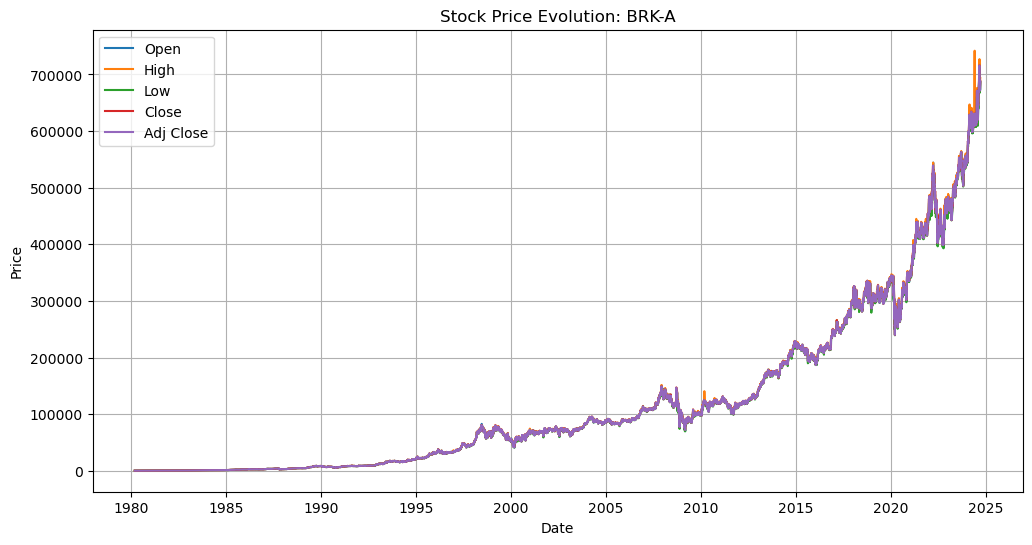

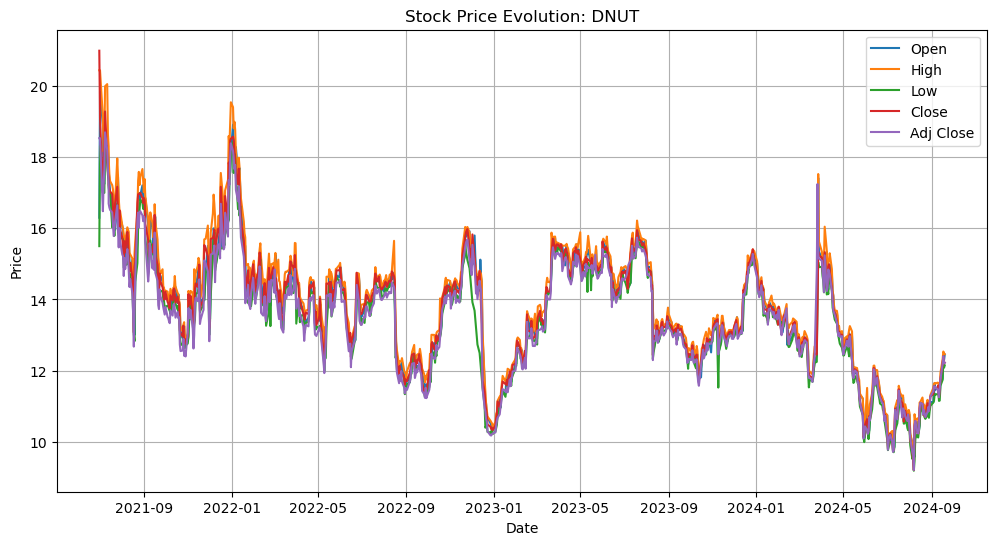

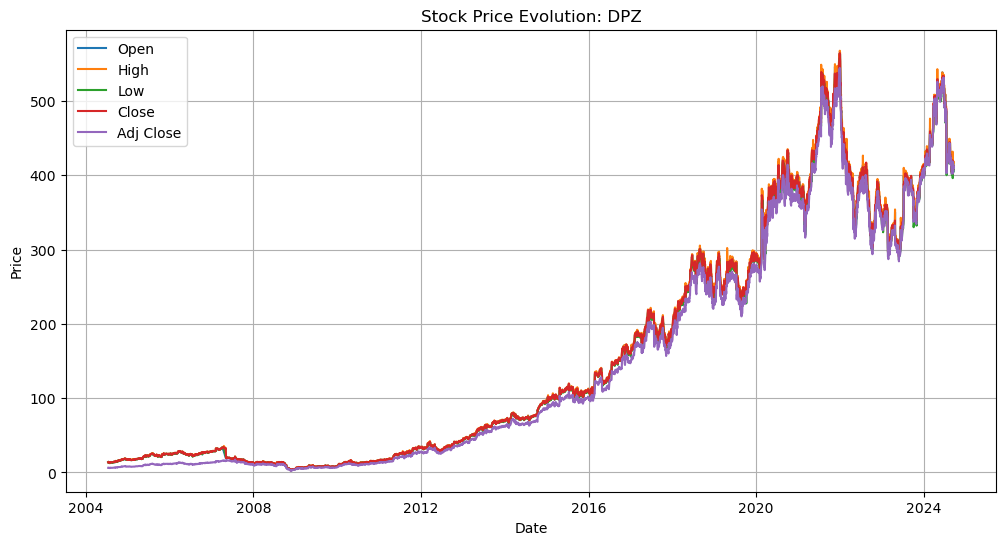

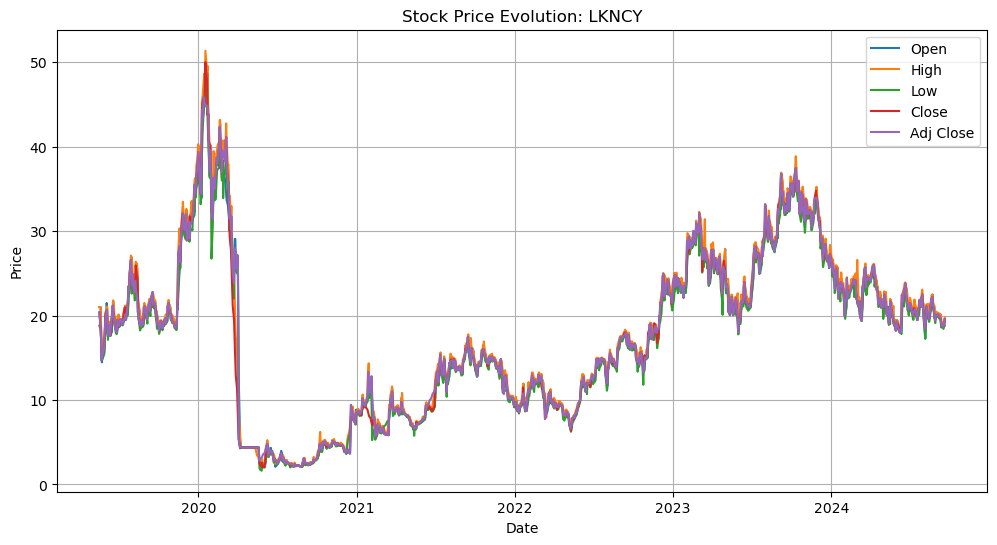

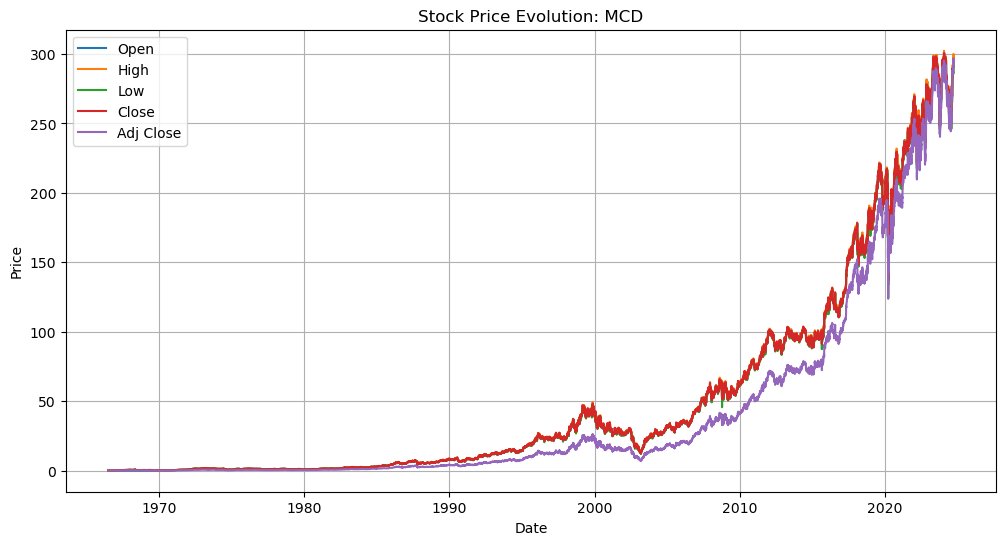

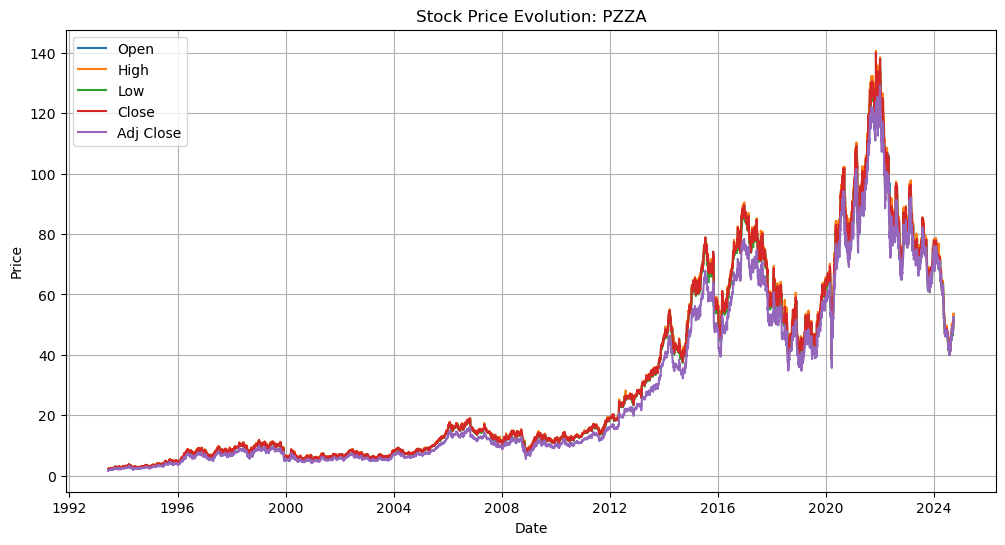

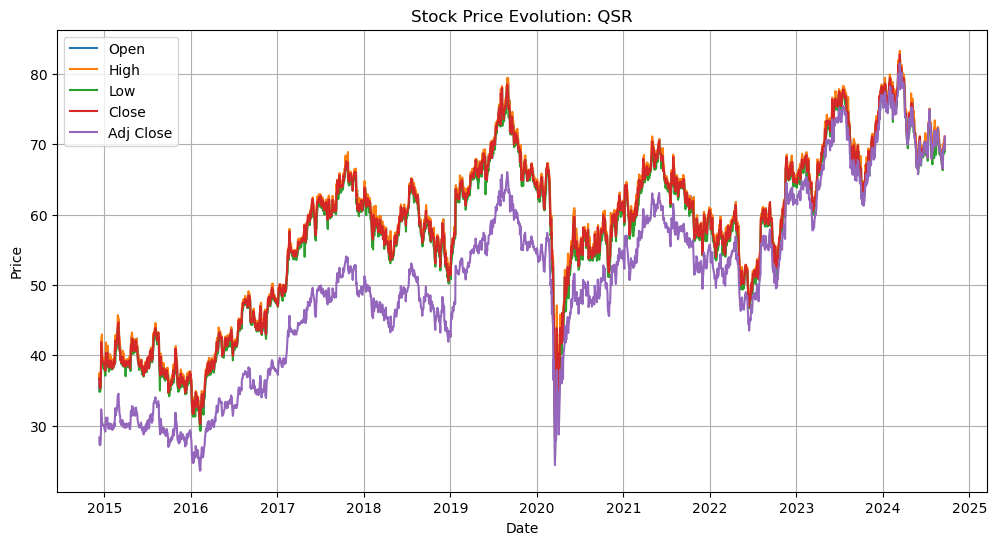

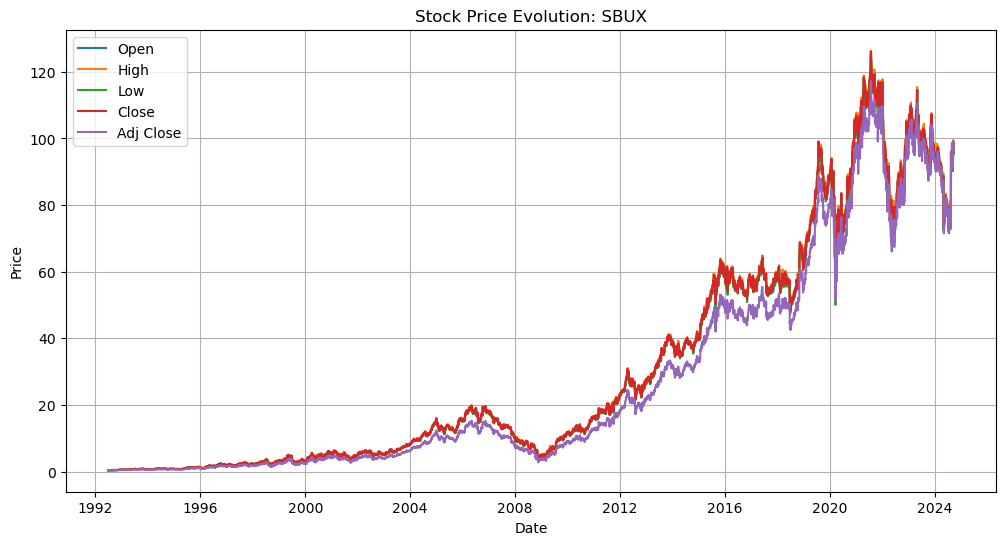

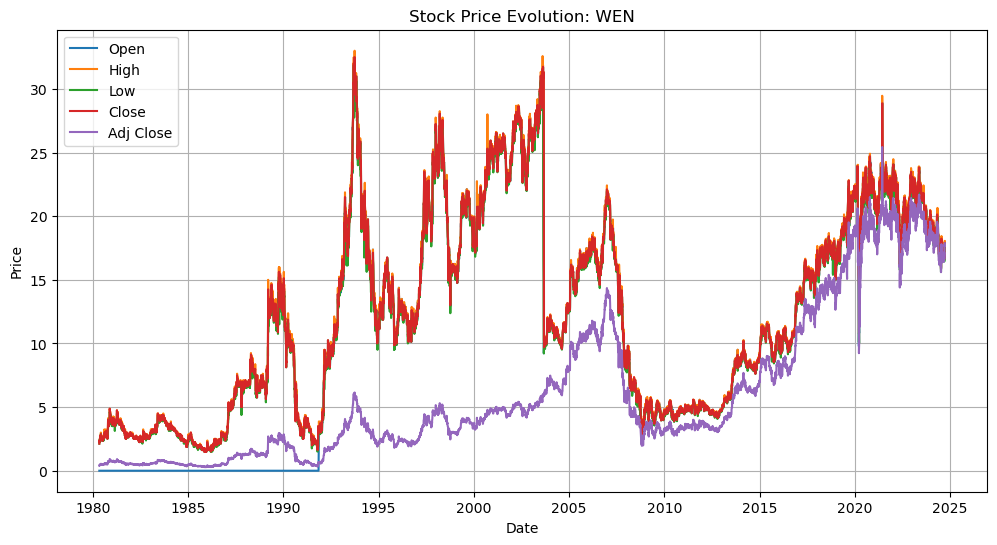

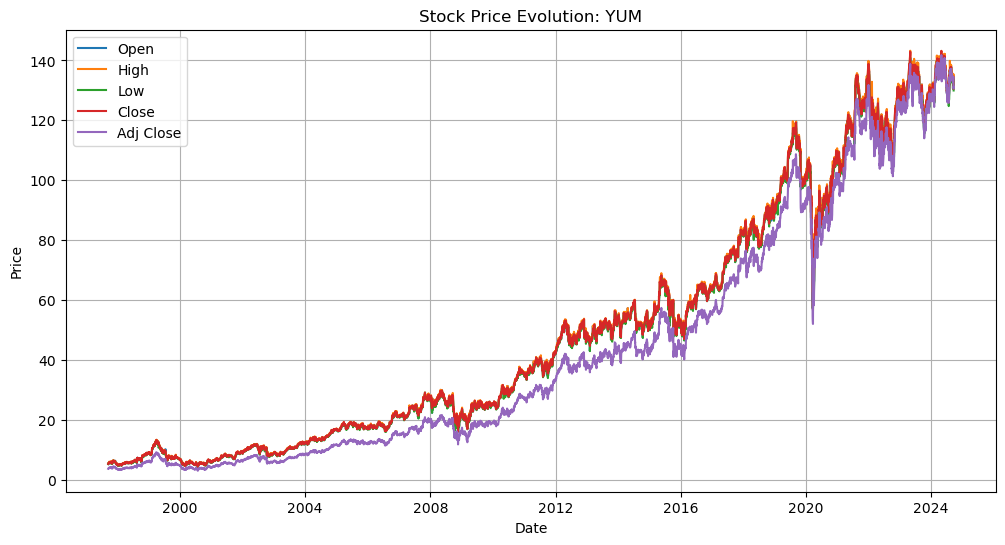

In [15]:
for df in dataframes:
    # Ensure the 'Date' column is parsed as datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort the data by date for proper plotting
    df.sort_values('Date', inplace=True)
    
    # Plot the line chart
    plt.figure(figsize=(12, 6))
    for variable in num_columns[:-1]:
        plt.plot(df["Date"], df[variable], label=variable)
    # plt.plot(df['Date'], df['Open'], label='Open')
    # plt.plot(df['Date'], df['High'], label='High')
    # plt.plot(df['Date'], df['Low'], label='Low')
    # plt.plot(df['Date'], df['Close'], label='Close')
    # plt.plot(df['Date'], df['Adj Close'], label='Adj Close')
    
    # Chart formatting
    plt.title(f"Stock Price Evolution: {df["Company"][0]}")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
results = []
company_names = []

for df in dataframes:
    company_name = df["Company"][0]
    company_names.append(company_name)
    total_rows = len(df)
    null_percentages = (df.isnull().sum() / total_rows) * 100
    
    result = {"Company": company_name}
    result.update(null_percentages.to_dict())
    results.append(result)

final_df = pd.DataFrame(results, index=company_names)
final_df = final_df.round(2)
final_df

Company  Date  Open  High  Low  Close  Adj Close  Volume
BRK-A      0.0   0.0   0.0   0.0  0.0    0.0        0.0   58.30
DNUT       0.0   0.0   0.0   0.0  0.0    0.0        0.0   41.84
DPZ        0.0   0.0   0.0   0.0  0.0    0.0        0.0   46.97
LKNCY      0.0   0.0   0.0   0.0  0.0    0.0        0.0   57.41
MCD        0.0   0.0   0.0   0.0  0.0    0.0        0.0   45.94
PZZA       0.0   0.0   0.0   0.0  0.0    0.0        0.0   54.00
QSR        0.0   0.0   0.0   0.0  0.0    0.0        0.0   38.51
SBUX       0.0   0.0   0.0   0.0  0.0    0.0        0.0   42.35
WEN        0.0   0.0   0.0   0.0  0.0    0.0        0.0   58.66
YUM        0.0   0.0   0.0   0.0  0.0    0.0        0.0   42.61

### 1. For each dataset:
- Print the number of rows and columns.
- Display the column names and their data types.

In [17]:
# Iterate over files in the directory
for df in dataframes:
    # Print the dataset name
    print(f"{df["Company"][0]}:")
    # Print the shape of the DataFrame
    print(f"- Number of rows and columns: {df.shape}")
    # Print the column names
    print(f"- Columns: {list(df.columns)}")
    # Print the data types of each column
    print(f"- Data types:")
    print(df.dtypes)
    print("-" * 50)  # Separator for readability

BRK-A:
- Number of rows and columns: (11227, 8)
- Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Company']
- Data types:
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
Company              object
dtype: object
--------------------------------------------------
DNUT:
- Number of rows and columns: (815, 8)
- Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Company']
- Data types:
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
Company              object
dtype: object
--------------------------------------------------
DPZ:
- Number of rows and columns: (5088, 8)
- Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Company'

### 2. Extract all rows where the date is in the year 2023.
- Print the number of rows.
- Visualize the `Close` price trend for this period.

In [18]:
for df in dataframes:
    company_name = df["Company"][0]
    df_2023 = df[df["Date"].dt.year == 2023]
    print(f"The number of observations for {company_name} for year 2023 is {df_2023.shape[0]}")

The number of observations for BRK-A for year 2023 is 250
The number of observations for DNUT for year 2023 is 252
The number of observations for DPZ for year 2023 is 250
The number of observations for LKNCY for year 2023 is 251
The number of observations for MCD for year 2023 is 250
The number of observations for PZZA for year 2023 is 250
The number of observations for QSR for year 2023 is 250
The number of observations for SBUX for year 2023 is 250
The number of observations for WEN for year 2023 is 251
The number of observations for YUM for year 2023 is 250


In [19]:
dfm["Date"] = pd.to_datetime(dfm["Date"], format="%Y-%m-%d")
dfm_2023 = dfm[dfm["Date"].dt.year == 2023]
print(f"The number of observations in the merged dataframe for year 2023 is {dfm_2023.shape[0]}")

The number of observations in the merged dataframe for year 2023 is 2504


### 3. For each company, find the day with the highest `Close` price.
- Display the date alongside the price.


In [20]:
# Dictionary to store results
results = {"Company": [], "Close": [], "Date": []}

for df in dataframes:
    # Extract the company name
    company_name = df["Company"].iloc[0]
    
    # Find the day with the highest Close price
    max_close_row = df.loc[df["Close"].idxmax()]
    max_date = max_close_row["Date"]
    max_close_price = max_close_row["Close"]
    
    # Append to results dictionary
    results["Company"].append(company_name)
    results["Close"].append(max_close_price)
    results["Date"].append(max_date)

# Display the results

results_df = pd.DataFrame(results)
print(results_df)



  Company          Close       Date
0   BRK-A  715910.000000 2024-09-03
1    DNUT      21.000000 2021-07-01
2     DPZ     564.330017 2021-12-31
3   LKNCY      50.020000 2020-01-17
4     MCD     300.529999 2024-01-19
5    PZZA     140.009995 2021-11-04
6     QSR      82.750000 2024-03-13
7    SBUX     126.059998 2021-07-26
8     WEN      32.500000 1993-09-29
9     YUM     143.190002 2024-04-29



### 4. Group the data by month and calculate the average `Close` price for each company.
- Plot these monthly averages for 3 companies and compare them.
- Justify the chart selection.

In [21]:
monthly_averages = []

for df in dataframes:
    # Convert Date column to datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    # Extract Year-Month for grouping
    df['YearMonth'] = df['Date'].dt.to_period('M')
    # Group by YearMonth and calculate average Close price
    company_avg = df.groupby('YearMonth')['Close'].mean().reset_index()
    # Add the Company column
    company_avg['Company'] = df['Company'].iloc[0]
    # Append to the results list
    monthly_averages.append(company_avg)

# monthly_averages is a list that contains 10 DataFrames, 1 for each company

# Combine all processed DataFrames into one
final_monthly_avg = pd.concat(monthly_averages, ignore_index=True)

# Display the result
print(final_monthly_avg)




     YearMonth       Close Company
0      1980-03  278.181818   BRK-A
1      1980-04  262.976190   BRK-A
2      1980-05  300.952381   BRK-A
3      1980-06  312.857143   BRK-A
4      1980-07  323.977273   BRK-A
...        ...         ...     ...
3316   2024-05  137.349318     YUM
3317   2024-06  136.486841     YUM
3318   2024-07  128.878408     YUM
3319   2024-08  136.126817     YUM
3320   2024-09  133.214615     YUM

[3321 rows x 3 columns]


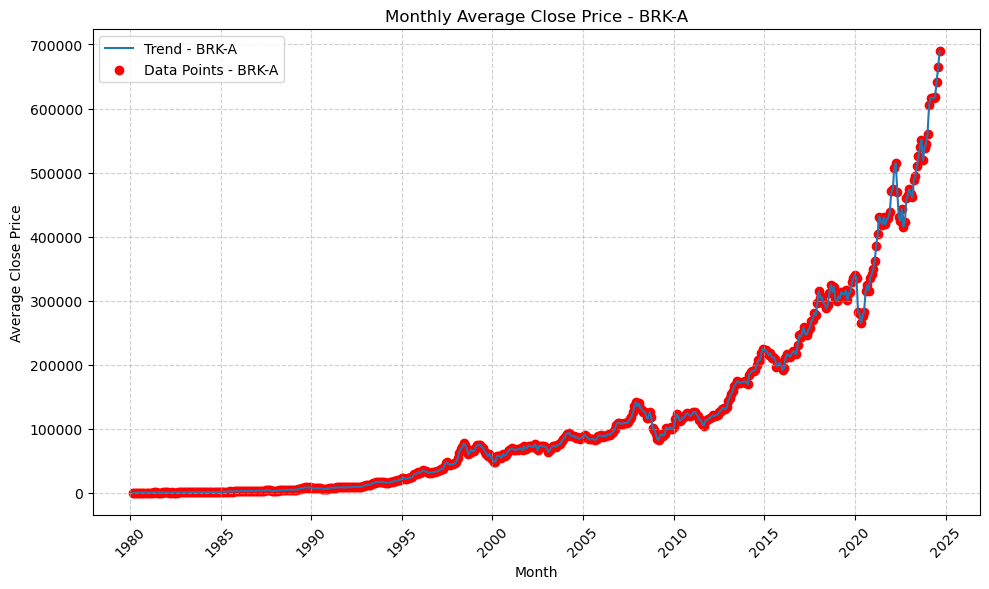

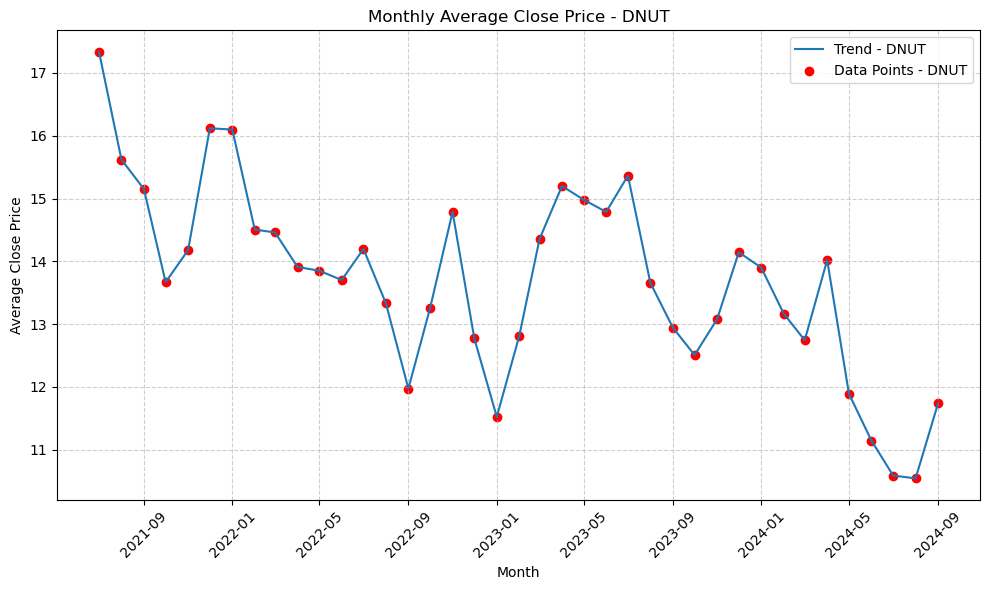

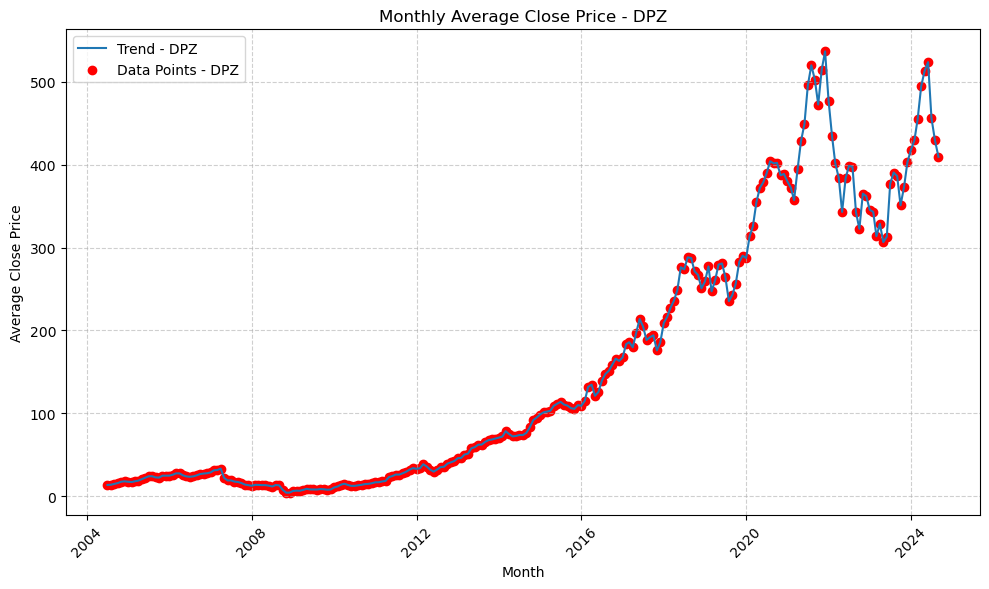

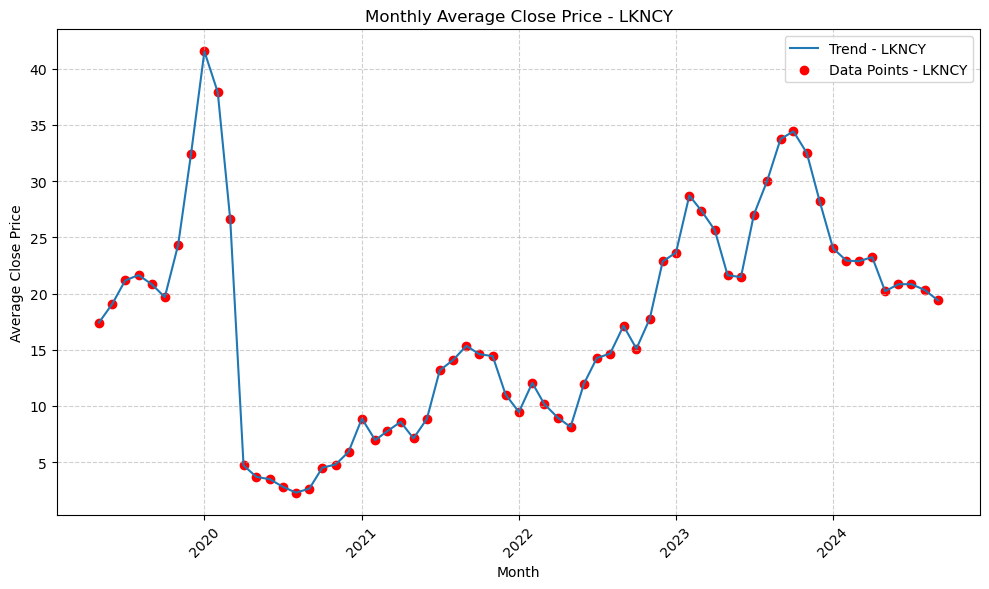

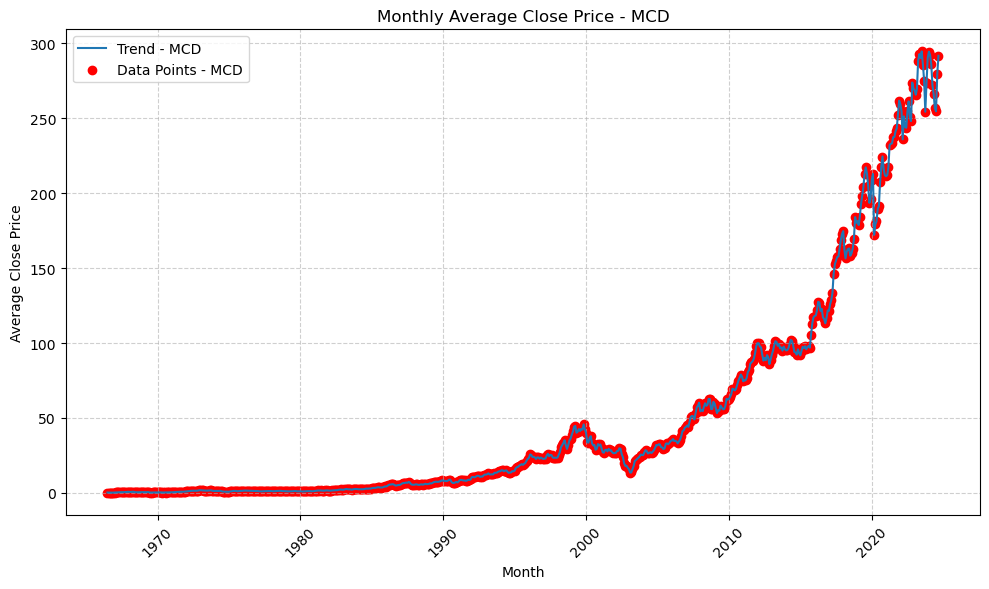

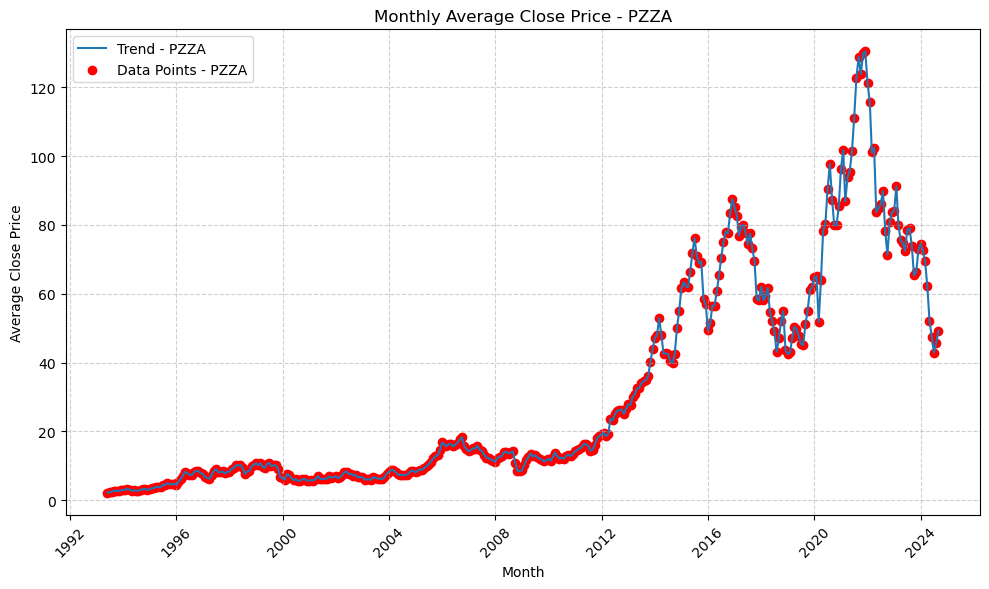

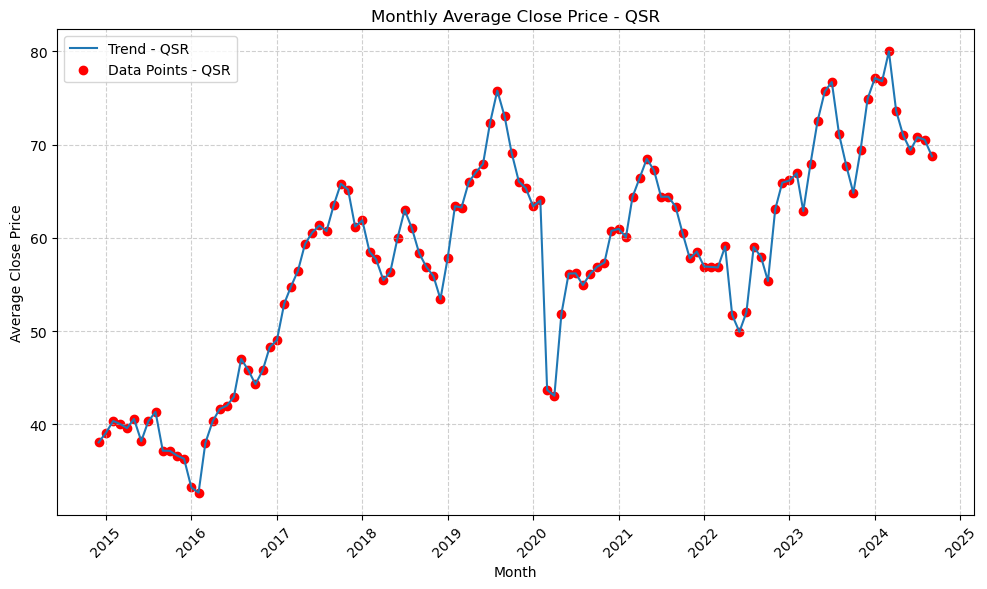

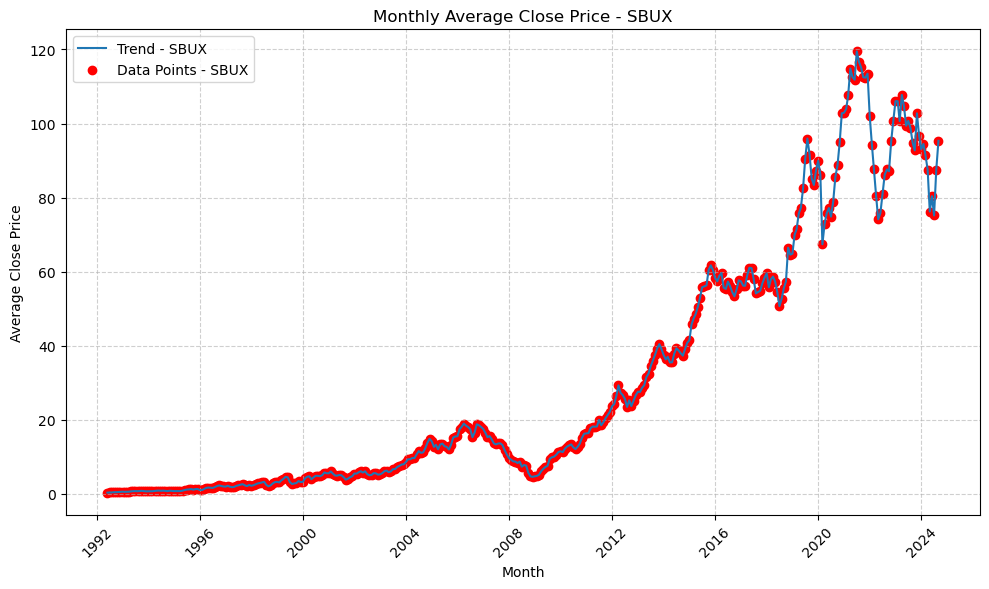

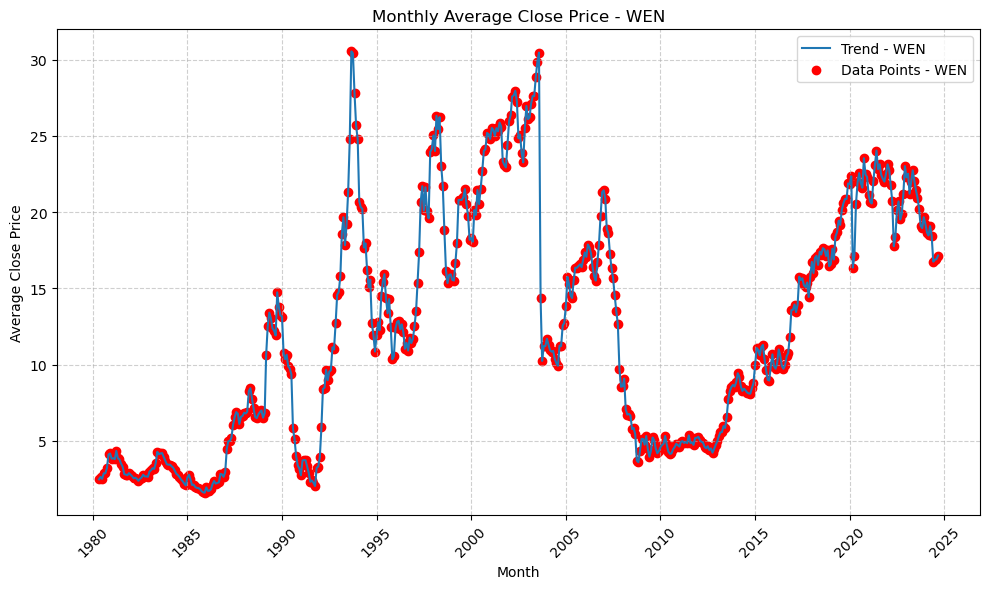

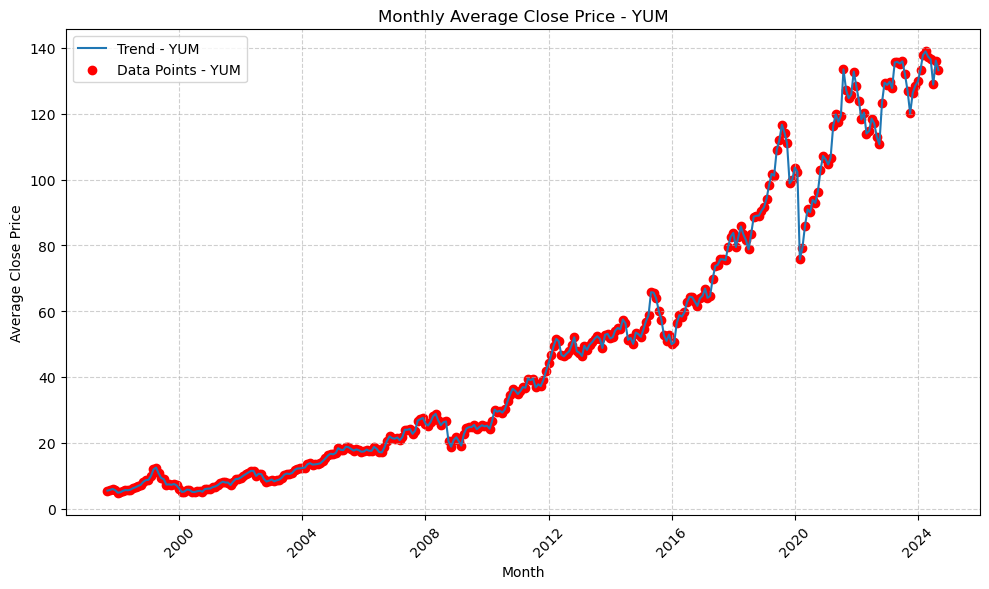

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Create separate enhanced charts for each company
for df in monthly_averages:
    # Ensure YearMonth is in datetime format
    df['YearMonth'] = pd.to_datetime(df['YearMonth'].astype(str))
    
    # Plot line and scatter
    plt.figure(figsize=(10, 6))
    plt.plot(df['YearMonth'], df['Close'], linestyle='-', label=f"Trend - {df['Company'].iloc[0]}")
    plt.scatter(df['YearMonth'], df['Close'], color='red', label=f"Data Points - {df['Company'].iloc[0]}")
    
    # Add chart details
    plt.title(f"Monthly Average Close Price - {df['Company'].iloc[0]}")
    plt.xlabel("Month")
    plt.ylabel("Average Close Price")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### 5. For each company:
- Compute the yearly average of the `Close` price.
- Plot a comparison of yearly averages for all companies on a chart.
- Justify your chart selection.

### 6. For each company, create a plot showing the range of prices for each month.
- Justify the chart selection.


### 7. Create a plot showing the relationship between trading volume and the `Close` price for a selected company.
- Add insights about the pattern and justify your chart selection.


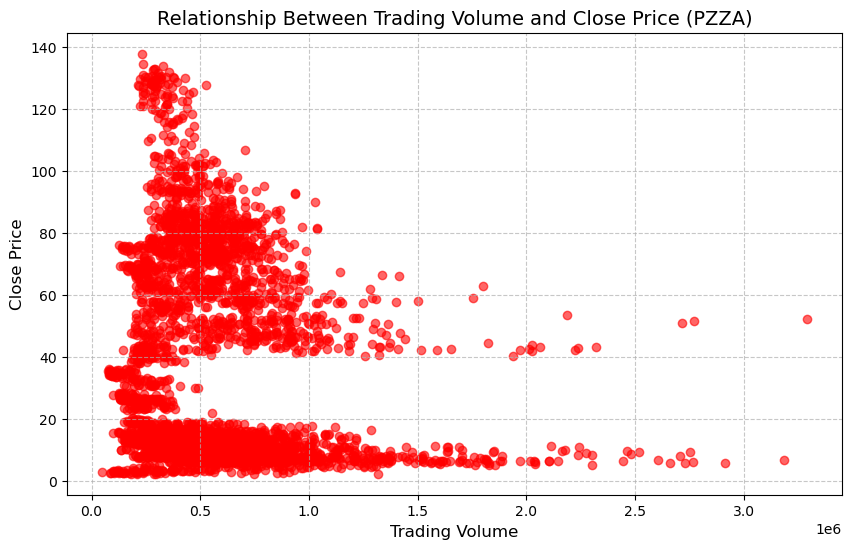

In [23]:
# Find the DataFrame for the company "PZZA"
pzza_data = [df for df in dataframes if df['Company'].iloc[0] == 'PZZA'][0]  # Filter by company name

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(pzza_data['Volume'], pzza_data['Close'], alpha=0.6, color='red')
plt.title('Relationship Between Trading Volume and Close Price (PZZA)', fontsize=14)
plt.xlabel('Trading Volume', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#### Insights about the pattern :- 

1. **Relationship Observation:**

    - The scatter plot reveals a non linear pattern and most data points are clustered at lower trading values (close to 0) and lower Close Prices (under 100), indicating that low trading activity is common for PZZA. 

2. **Distinct Clusters:**

    - There are horizontal clusters in the data such as around Close Prices of 20, 60 and 100, suggesting that these prices levels may be recurring or significant for the company. 

3. **Spare High Volume Activity:**

    - Trading volumes exceeding 2.5 million are rare and such instances occur accross a broad range of Close Prices. 


#### Justification for Chart Selection:

1. **Shows Relationships Carefully:**

    -  A scatter plot is the best choice for visualizing the relationship between two continuous variables—Trading Volume and Close Price—allowing us to observe patterns, clusters, and outliers effectively.
    
2.  **Highlights Trends and Anomalies:** 

    - It enables easy identification of trends and outliers which are critical for analysis.

3.  **Avoids Misrepresentation:**

    -  Other charts, like bar or line plots, would not work well since the data does not follow a time sequence or a category-based structure. 



### 8. For each company, identify the month with the highest total trading volume.
- Display the results in a summary table, showing the month and total volume.

In [24]:
# Dictionary to store results
results = {"Company": [], "Highest Volume Month": [], "Total Volume": []}

for df in dataframes:
    # Extract the company name
    company_name = df["Company"].iloc[0]

    # Group by 'Month' and calculate total volume
    monthly_volume = df.groupby("Month")["Volume"].sum()

    # Find the month with the highest trading volume
    max_volume_month = monthly_volume.idxmax()
    max_volume = monthly_volume[max_volume_month]

    # Append to results dictionary
    results["Company"].append(company_name)
    results["Highest Volume Month"].append(max_volume_month)
    results["Total Volume"].append(round(max_volume / 1e6, 2))  # Convert to millions and round

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df.to_string(index=False))


KeyError: 'Month'

### 9. Merge the datasets for all companies into a single dataset, one for each year.
- Print the structure of the combined dataset.
- Ensure proper alignment and handling of missing values.

In [25]:
merged_df = pd.concat(dataframes, ignore_index=True)
merged_df

Date        Open        High         Low       Close   Adj Close  \
0     1980-03-17  290.000000  310.000000  290.000000  290.000000  290.000000   
1     1980-03-18  290.000000  290.000000  290.000000  290.000000  290.000000   
2     1980-03-19  290.000000  310.000000  290.000000  290.000000  290.000000   
3     1980-03-20  290.000000  290.000000  290.000000  290.000000  290.000000   
4     1980-03-21  290.000000  290.000000  290.000000  290.000000  290.000000   
...          ...         ...         ...         ...         ...         ...   
69589 2024-09-13  133.479996  133.949997  132.929993  133.649994  133.649994   
69590 2024-09-16  134.034996  135.479996  133.789993  134.559998  134.559998   
69591 2024-09-17  134.589996  135.210007  132.160004  132.350006  132.580002   
69592 2024-09-18  132.399994  133.100006  130.270004  130.600006  130.600006   
69593 2024-09-19  132.119995  132.509995  129.970001  130.600006  131.089996   

          Volume Company YearMonth  
0            NaN   BRK-A   1980-03  
1            0.0   BRK-A   1980-03  
2            NaN   BRK-A   1980-03  
3            0.0   BRK-A   1980-03  
4            0.0   BRK-A   1980-03  
...          ...     ...       ...  
69589  1811500.0     YUM   2024-09  
69590  1929300.0     YUM   2024-09  
69591  2009600.0     YUM   2024-09  
69592  2186200.0     YUM   2024-09  
69593        NaN     YUM   2024-09  

[69594 rows x 9 columns]

In [27]:
first_year = merged_df['Date'].dt.year.min()  # Get the first year in the dataset
recent_year = merged_df['Date'].dt.year.max()
merged_df['Year'] = merged_df['Date'].dt.year # Add year column

# Create a dictionary to hold the dataframes for each year
year_dfs = {}

# Loop through each year and create a dataframe for that year
for year in range(first_year, recent_year + 1):
    year_dfs[year] = merged_df[merged_df['Year'] == year].copy()


We can access each years specific dataset by calling the year dictionary with the desired year as the key. Here is an example for year 2024:

In [28]:
year_dfs[2024]

Date           Open           High            Low          Close  \
11046 2024-01-02  539496.000000  550500.000000  543603.000000  549787.000000   
11047 2024-01-03  549272.000000  557900.000000  547106.000000  556050.000000   
11048 2024-01-04  557707.000000  560400.000000  551100.000000  551550.000000   
11049 2024-01-05  555300.000000  555684.000000  549896.000000  554300.000000   
11050 2024-01-08  556848.000000  558830.000000  552240.000000  555400.000000   
...          ...            ...            ...            ...            ...   
69589 2024-09-13     133.479996     133.949997     132.929993     133.649994   
69590 2024-09-16     134.034996     135.479996     133.789993     134.559998   
69591 2024-09-17     134.589996     135.210007     132.160004     132.350006   
69592 2024-09-18     132.399994     133.100006     130.270004     130.600006   
69593 2024-09-19     132.119995     132.509995     129.970001     130.600006   

           Adj Close     Volume Company YearMonth  Year  
11046  549787.000000        NaN   BRK-A   2024-01  2024  
11047  556050.000000     9500.0   BRK-A   2024-01  2024  
11048  551550.000000     9100.0   BRK-A   2024-01  2024  
11049  554300.000000     8100.0   BRK-A   2024-01  2024  
11050  558780.000000        NaN   BRK-A   2024-01  2024  
...              ...        ...     ...       ...   ...  
69589     133.649994  1811500.0     YUM   2024-09  2024  
69590     134.559998  1929300.0     YUM   2024-09  2024  
69591     132.580002  2009600.0     YUM   2024-09  2024  
69592     130.600006  2186200.0     YUM   2024-09  2024  
69593     131.089996        NaN     YUM   2024-09  2024  

[1812 rows x 10 columns]

Here is an example of the stucture of these yearly datasets. You can see there are only missing values for the volume which is discussed above.

In [29]:
year_dfs[2024].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1812 entries, 11046 to 69593
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1812 non-null   datetime64[ns]
 1   Open       1812 non-null   float64       
 2   High       1812 non-null   float64       
 3   Low        1812 non-null   float64       
 4   Close      1812 non-null   float64       
 5   Adj Close  1812 non-null   float64       
 6   Volume     1095 non-null   float64       
 7   Company    1812 non-null   object        
 8   YearMonth  1812 non-null   period[M]     
 9   Year       1812 non-null   int32         
dtypes: datetime64[ns](1), float64(6), int32(1), object(1), period[M](1)
memory usage: 148.6+ KB


Here is a visualization of what is now avaliable through these yearly datasets. The variable `High` is charted for each company in 2024 below excluding BRK-A for better visualization.

C:\Users\nelso\AppData\Local\Temp\ipykernel_8776\2774448423.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Log_High'] = np.log(df_filtered['High'])


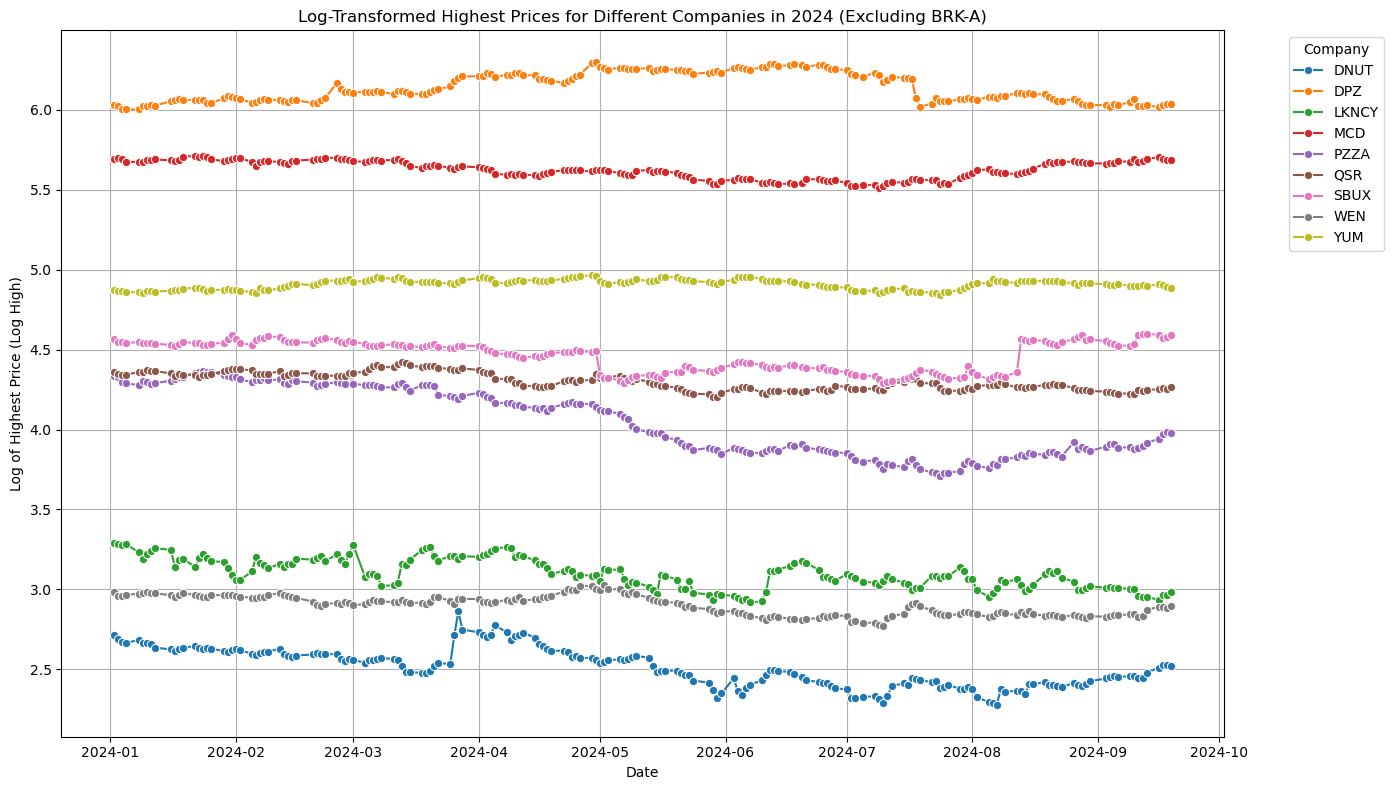

In [30]:
df_2024 = year_dfs[2024]

# Ensure 'Date' is in datetime format
df_2024['Date'] = pd.to_datetime(df_2024['Date'])

# Find the company with the highest average 'High' value
top_company = df_2024.groupby('Company')['High'].mean().idxmax()

# Filter out the top company
df_filtered = df_2024[df_2024['Company'] != top_company]

# Apply log transformation to the 'High' values
df_filtered['Log_High'] = np.log(df_filtered['High'])

# Create the Seaborn lineplot with the log-transformed 'High' values
plt.figure(figsize=(14, 8))

sns.lineplot(data=df_filtered, x='Date', y='Log_High', hue='Company', marker='o')

# Customize the plot
plt.title(f'Log-Transformed Highest Prices for Different Companies in 2024 (Excluding {top_company})')
plt.xlabel('Date')
plt.ylabel('Log of Highest Price (Log High)')


plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')  # Position legend outside the plot
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


### 10. For each company:
- Calculate the spread between the `High` and `Low` prices for each day.
- Calculate the average spread for each company and visualize the result in a chart.
- Justify the chart selection.
- Identify which companies exhibit the largest spreads and provide insights into their values.


In [31]:
average_spreads = {}

for df in dataframes:
    df['Spread'] = df['High'] - df['Low']
    # Calculate the average spread for the current dataframe
    avg_spread = df['Spread'].mean()
    average_spreads[df['Company'].iloc[0]] = avg_spread
    
    print(f"{df['Company'].iloc[0]} average daily spread between High and Low prices is: {avg_spread:.2f}")
    print("=============================================\n")

# The dictionary `average_spreads` now contains the average spread for each company
print("Average spreads for all companies:")
print(average_spreads)

BRK-A average daily spread between High and Low prices is: 1730.32

DNUT average daily spread between High and Low prices is: 0.54

DPZ average daily spread between High and Low prices is: 3.74

LKNCY average daily spread between High and Low prices is: 1.03

MCD average daily spread between High and Low prices is: 0.82

PZZA average daily spread between High and Low prices is: 0.93

QSR average daily spread between High and Low prices is: 1.21

SBUX average daily spread between High and Low prices is: 0.62

WEN average daily spread between High and Low prices is: 0.35

YUM average daily spread between High and Low prices is: 0.90

Average spreads for all companies:
{'BRK-A': 1730.3249755054778, 'DNUT': 0.5413650185052603, 'DPZ': 3.737359510699533, 'LKNCY': 1.0309566723417354, 'MCD': 0.8165195438427042, 'PZZA': 0.9295038699982782, 'QSR': 1.2071415295005572, 'SBUX': 0.6158188463204072, 'WEN': 0.3521879469713541, 'YUM': 0.8993606716372514}


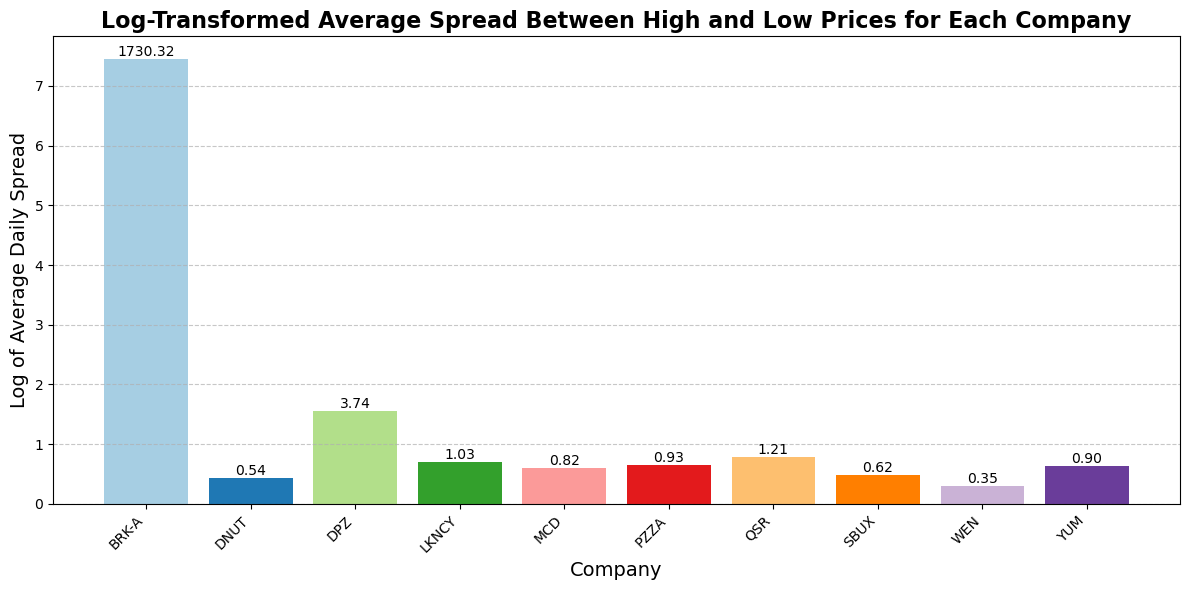

In [ ]:
companies = list(average_spreads.keys())
spreads = list(average_spreads.values())

# Apply log transformation to the spreads, adding a small constant to avoid log(0) errors
log_spreads = np.log(np.array(spreads) + 1)

# Set up Seaborn color palette and figure size
colors = sns.color_palette("Paired", len(companies))  # Use a different palette
plt.figure(figsize=(12, 6))  # Wider figure for better spacing

# Create a bar chart with different colors for each bar
bars = plt.bar(companies, log_spreads, color=colors)

# Add titles and labels
plt.title('Log-Transformed Average Spread Between High and Low Prices for Each Company', fontsize=16, fontweight='bold')
plt.xlabel('Company', fontsize=14)
plt.ylabel('Log of Average Daily Spread', fontsize=14)

# Annotate the actual spread value (not log-transformed) on top of each bar
for i, bar in enumerate(bars):
    yval = bar.get_height()
    actual_value = spreads[i]
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{actual_value:.2f}', ha='center', va='bottom', fontsize=10)

# Rotate the x-ticks for better readability
plt.xticks(rotation=45, ha='right')

# Optionally add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Assuming 'dataframes' is a list of your 10 dataframes for each company
volatility = []
average_volume = []
companies = [df['Company'].iloc[0] for df in dataframes]

# Calculate volatility and average volume for each company
for df in dataframes:
    # Calculate daily returns
    df['Daily Return'] = df['Close'].pct_change()

    # Add Volatility (30-day rolling window)
    df['Volatility'] = df['Daily Return'].rolling(window=30).std()

    # Add Average Volume (30-day rolling window, ignoring NaN values)
    df['Average Volume'] = df['Volume'].rolling(window=30, min_periods=1).mean()

    # Store the average volatility and average volume for each company
    volatility.append(df['Volatility'].mean())
    average_volume.append(df['Average Volume'].mean())

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Company': companies,
    'Average Volatility': volatility,
    'Average Volume': average_volume
})

# Display the summary
summary_df


Company  Average Volatility  Average Volume
0   BRK-A            0.011981    2.432797e+04
1    DNUT            0.025816    1.100347e+06
2     DPZ            0.019160    5.635376e+05
3   LKNCY            0.051694    3.245663e+06
4     MCD            0.015331    3.858221e+06
5    PZZA            0.021202    5.980231e+05
6     QSR            0.015868    1.373672e+06
7    SBUX            0.020118    1.279756e+07
8     WEN            0.024281    1.308920e+06
9     YUM            0.015878    3.491464e+06

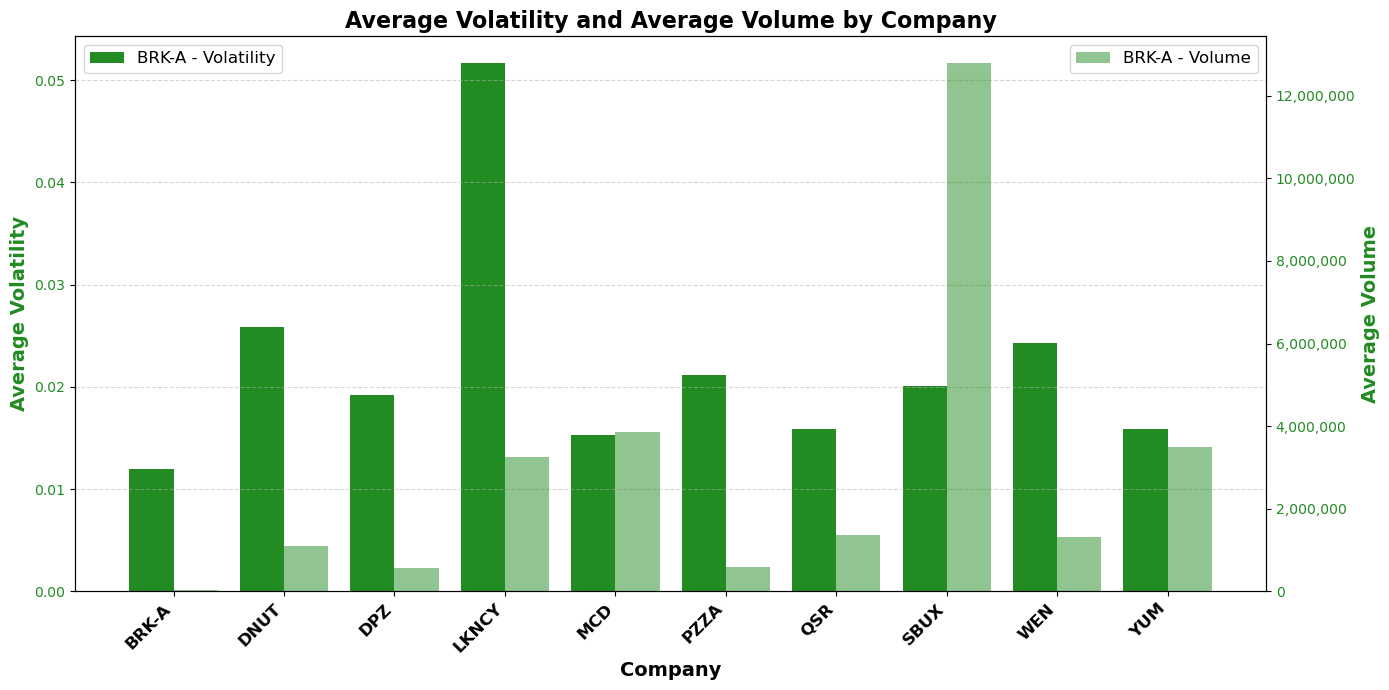

In [68]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Set the x positions for each company
x = np.arange(len(summary_df))

# Use a normal green color for both volatility and volume
common_color = '#228B22'  # Forest Green

# Plot Average Volatility with higher opacity
for i, company in enumerate(summary_df['Company']):
    ax1.bar(x[i] - 0.2, summary_df['Average Volatility'][i], width=0.4, color=common_color, alpha=1, label=f'{company} - Volatility' if i == 0 else "")

# Create another axis for Average Volume with lower opacity
ax2 = ax1.twinx()
for i, company in enumerate(summary_df['Company']):
    ax2.bar(x[i] + 0.2, summary_df['Average Volume'][i], width=0.4, color=common_color, alpha=0.5, label=f'{company} - Volume' if i == 0 else "")

# Set the labels and title with larger font sizes
ax1.set_xlabel('Company', fontsize=14, fontweight='bold')
ax1.set_ylabel('Average Volatility', color=common_color, fontsize=14, fontweight='bold')
ax2.set_ylabel('Average Volume', color=common_color, fontsize=14, fontweight='bold')
ax1.set_title('Average Volatility and Average Volume by Company', fontsize=16, fontweight='bold')

# Set the company names on the x-axis
ax1.set_xticks(x)
ax1.set_xticklabels(summary_df['Company'], rotation=45, ha='right', fontsize=12, fontweight='bold')

# Match the tick label colors with their respective axis label
ax1.tick_params(axis='y', labelcolor=common_color)
ax2.tick_params(axis='y', labelcolor=common_color)

# Set the right y-axis to show numbers in normal format (not scientific notation)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Add legends
ax1.legend(loc='upper left', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)

# Add grid lines with a lighter style
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)

# Tight layout to make sure everything fits
plt.tight_layout()
plt.show()

